C:\Users\yh1024\Box\LAB\Lab Folder\EXPERIMENTS\CONFOCAL EXPERIMENTS\FRET

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [2]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()


def calculate_average_intensity(image):
    """Calculate the average intensity of the image."""
    return np.mean(image)

def find_inclusion_mask(image):
    """Find the inclusion mask using otsu thresholding."""
    threshold = threshold_otsu(image)
    inclusion_mask = (image > threshold).astype(int)
    
    return inclusion_mask

In [3]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    # orange_channel, green_channel, red_channel = image_squeezed[:3]
    # show_image(orange_channel)
    # show_image(green_channel)
    # show_image(red_channel)

    # find image with max average intensity
    max_average_intensity = 0
    max_average_intensity_image = None
    for c in range(image_squeezed.shape[0]):
        channel = image_squeezed[c, :, :]
        average_intensity = calculate_average_intensity(channel)
        if average_intensity > max_average_intensity:
            max_average_intensity = average_intensity
            max_average_intensity_image = channel

    mask = find_inclusion_mask(max_average_intensity_image)
    show_image(mask)
    inverse_mask = 1 - mask
    show_image(inverse_mask)
    
    intensities_without_inclusions = []
    intensities_only_inclusions = []
    intensities_whole_image = []
    for c in range(image_squeezed.shape[0]):
        channel = image_squeezed[c, :, :]
        average_intensity_whole_image = calculate_average_intensity(channel)
        intensities_whole_image.append(average_intensity_whole_image)
        # show_image(green_channel)
        applied_mask_without_inclusions = channel[inverse_mask]

        applied_mask_only_inclusions = channel [mask]

        average_intensity_without_inclusions = calculate_average_intensity(applied_mask_without_inclusions)
        intensities_without_inclusions.append(average_intensity_without_inclusions)
        average_intensity_only_inclusions = calculate_average_intensity(applied_mask_only_inclusions)
        intensities_only_inclusions.append(average_intensity_only_inclusions)



    df1 = pd.DataFrame({
            "File_Name:": [basename],
            "Orange_Average_Intensity_Whole_Image": [intensities_whole_image[0]],
            "Orange_Intensity_Without_Inclusions": [intensities_without_inclusions[0]],
            "Orange_Intensity_Only_Inclusions": [intensities_only_inclusions[0]],
            "Green_Average_Intensity_Whole_Image": [intensities_whole_image[1]],
            "Green_Intensity_Without_Inclusions": [intensities_without_inclusions[1]],
            "Green_Intensity_Only_Inclusions": [intensities_only_inclusions[1]],
            "Red_Average_Intensity_Whole_Image": [intensities_whole_image[2]],
            "Red_Intensity_Without_Inclusions": [intensities_without_inclusions[2]],
            "Red_Intensity_Only_Inclusions": [intensities_only_inclusions[2]],
            "Orange_to_Green_Ratio_Whole_Image": [intensities_whole_image[0] / intensities_whole_image[1]],
            "Orange_to_Green_Ratio_Without_Inclusions": [intensities_without_inclusions[0] / intensities_without_inclusions[1]],
            "Orange_to_Green_Ratio_Only_Inclusions": [intensities_only_inclusions[0] / intensities_only_inclusions[1]],
    })
    
    
    return df1


In [4]:
def analyze_all_images(image_folder):
    all_data_1 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)
            # if "conventional" in well_image.lower():
            #     continue

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    file_name = image_folder.replace("/", "_")
    combined_df_1.to_excel(f"{file_name}_analysis.xlsx", index=False)

def analyze_all_subfolders(parent_folder):
    for folder in os.listdir(parent_folder):
        if os.path.isdir(os.path.join(parent_folder, folder)):
            analyze_all_images(os.path.join(parent_folder, folder))

Define Main Function

In [5]:
# folders = ['012025_FRET_optimization/new_settings','012725_FRET_optimize/C12_settings','012725_FRET_optimize/Lipidtox_settings']
# folders = ['021725_FRET_Optimization/490_550','021725_FRET_Optimization/490_600','021725_FRET_Optimization/500_550']
folder = '022425_FRET_Optimization'

Bodipy_493-503_conventional_image_01.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


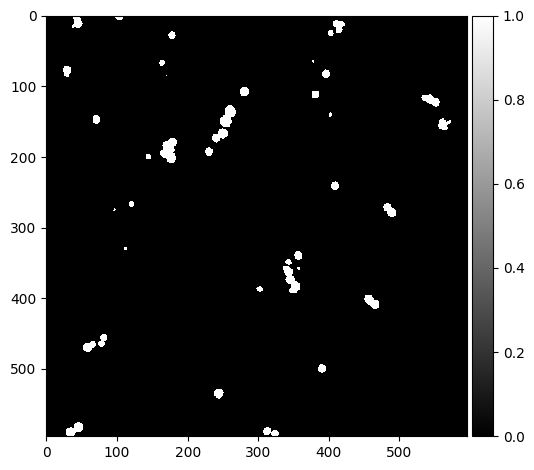

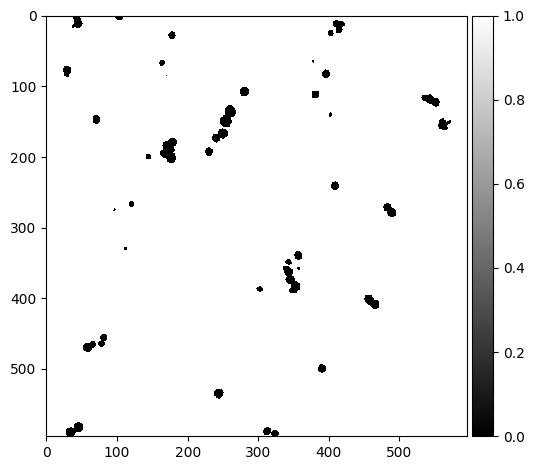

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_02.czi


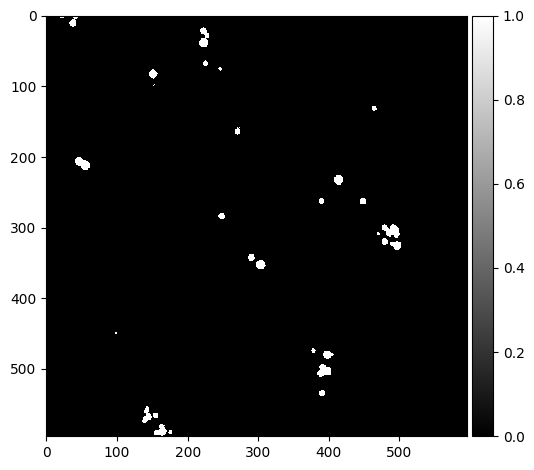

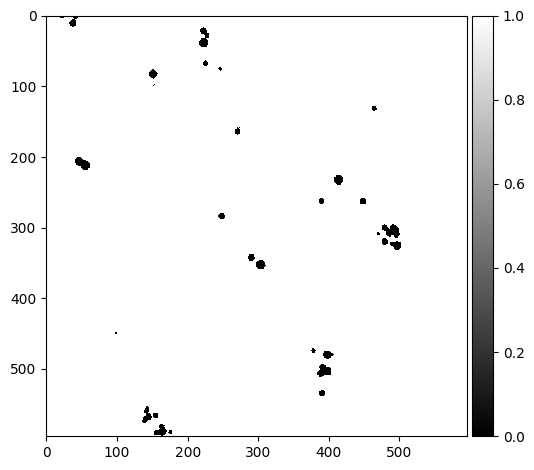

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_03.czi


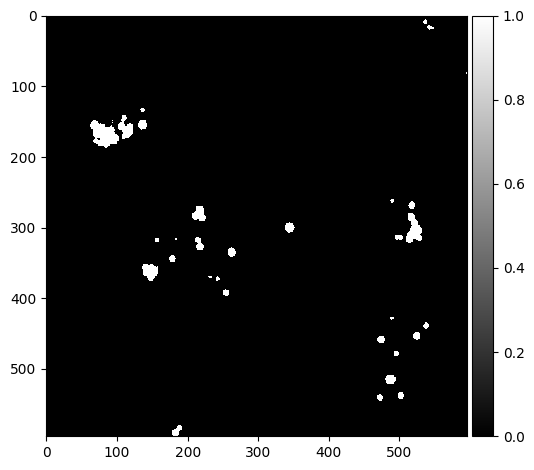

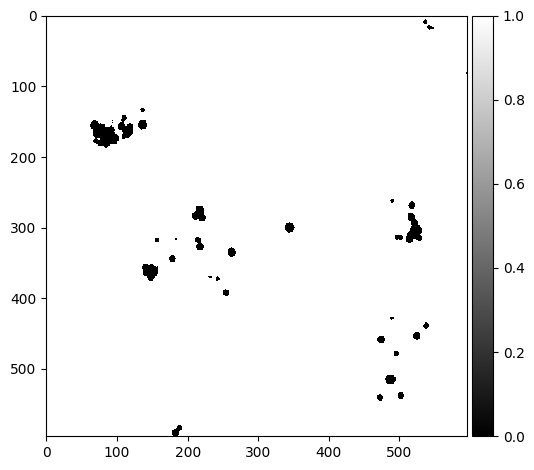

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_04.czi


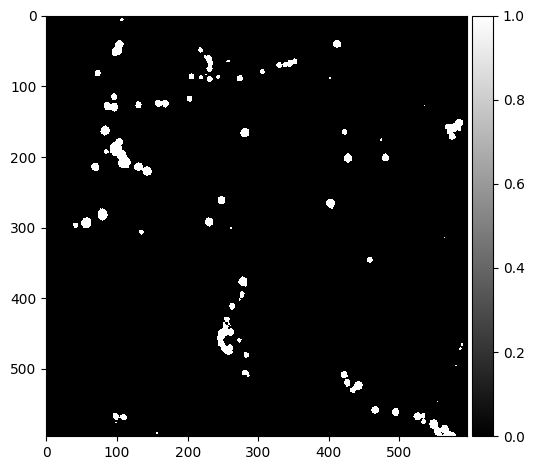

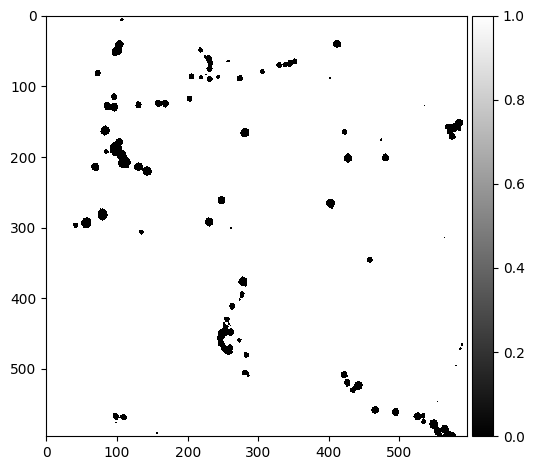

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_05.czi


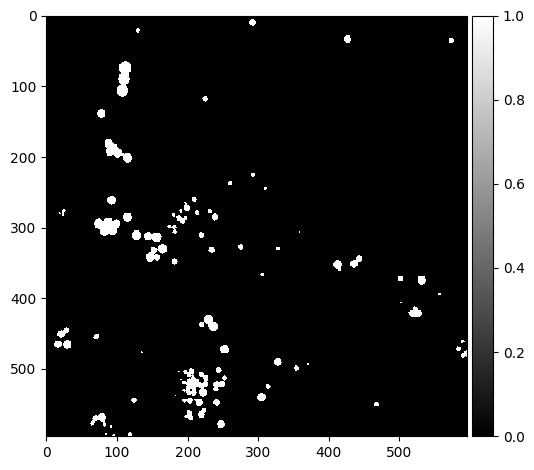

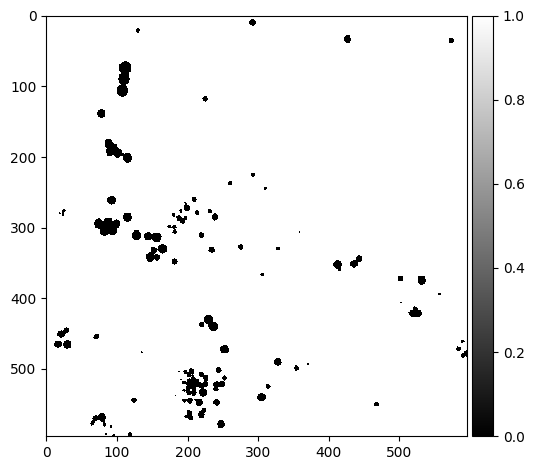

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_06.czi


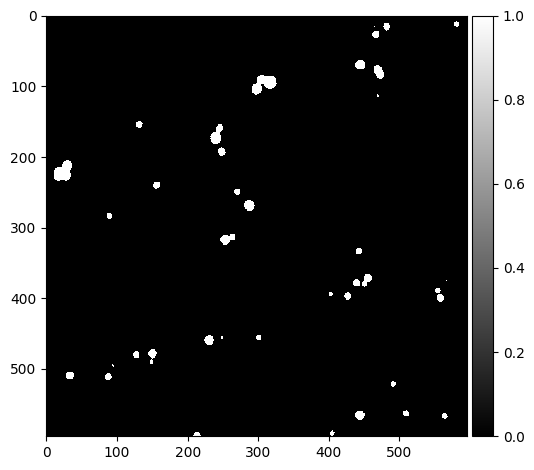

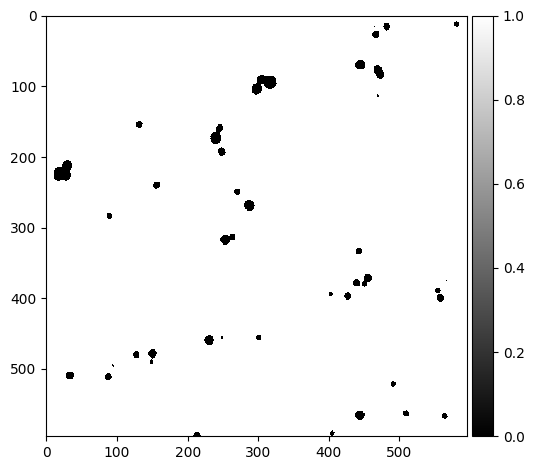

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_07.czi


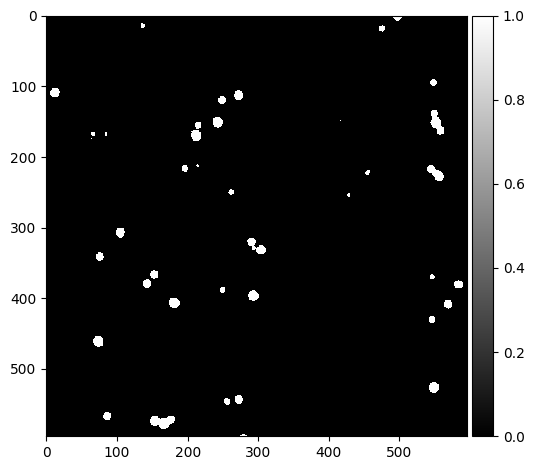

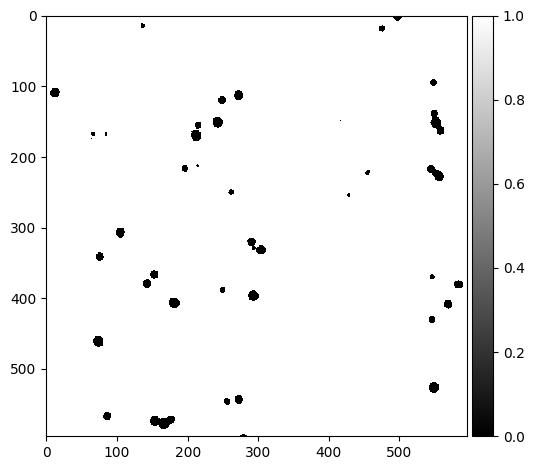

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_08.czi


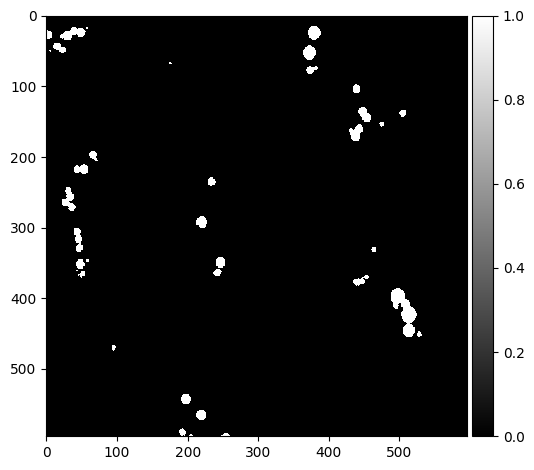

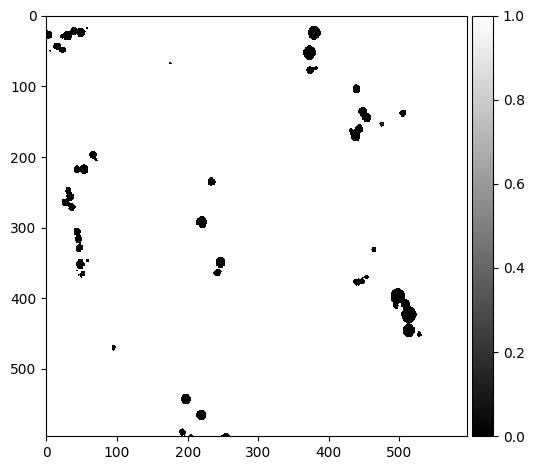

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_01.czi


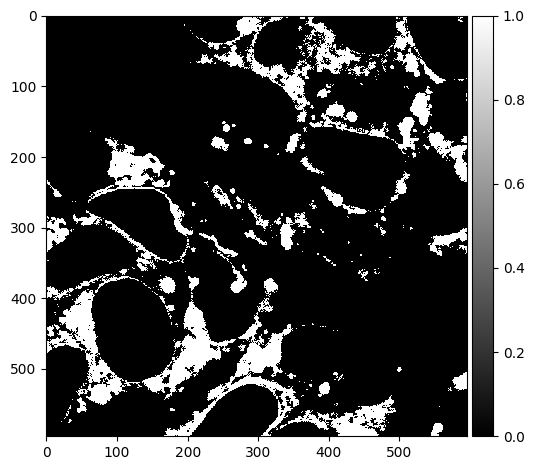

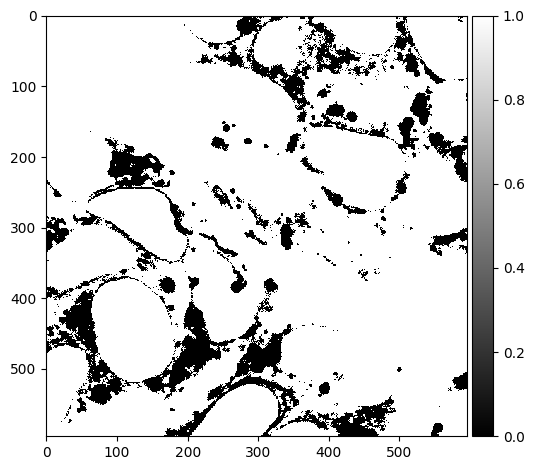

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_02.czi


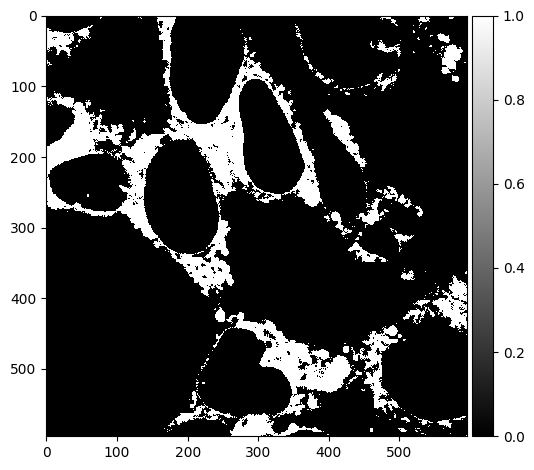

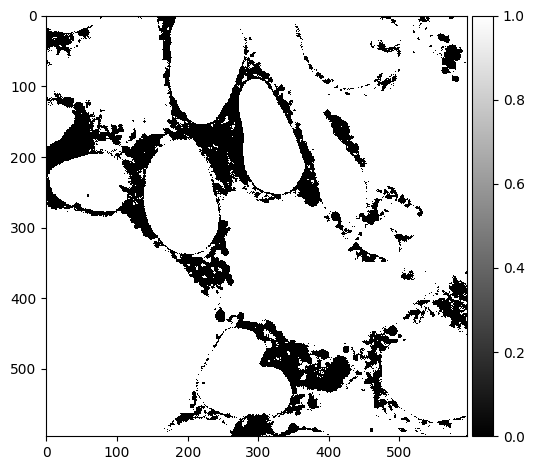

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_03.czi


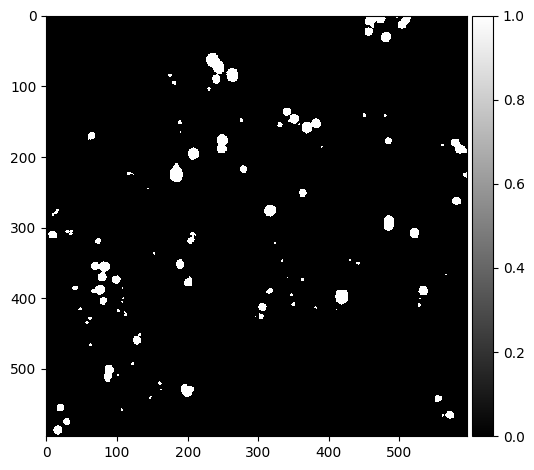

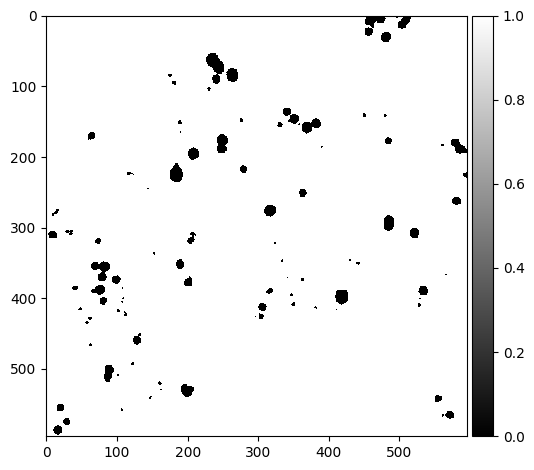

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_04.czi


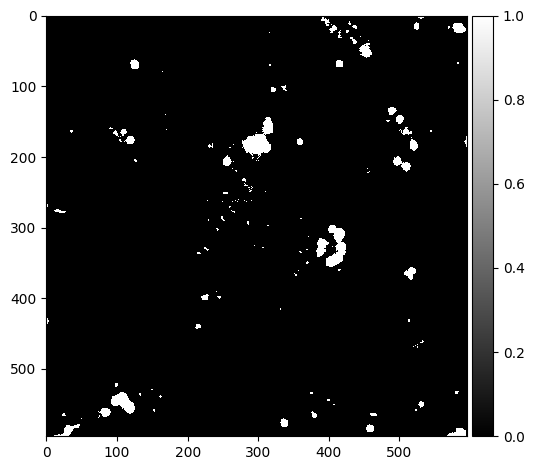

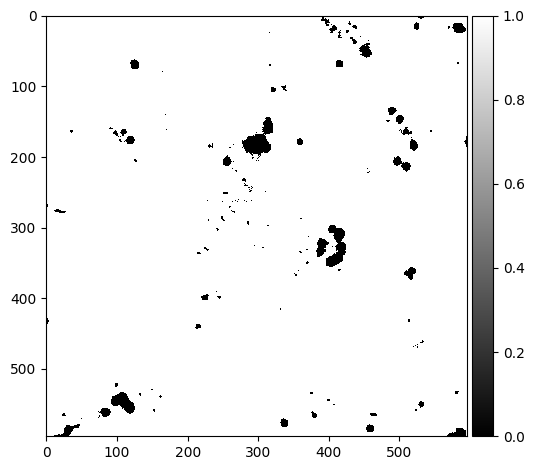

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_05.czi


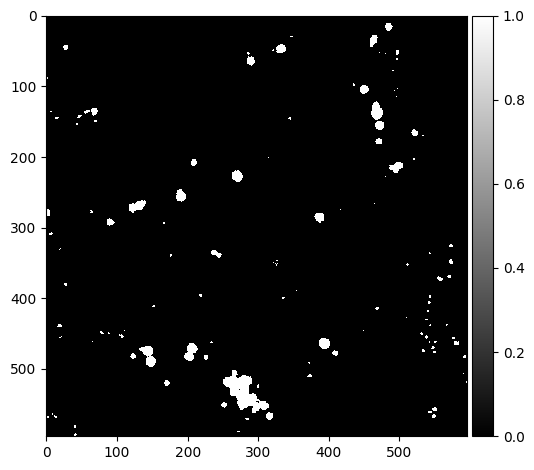

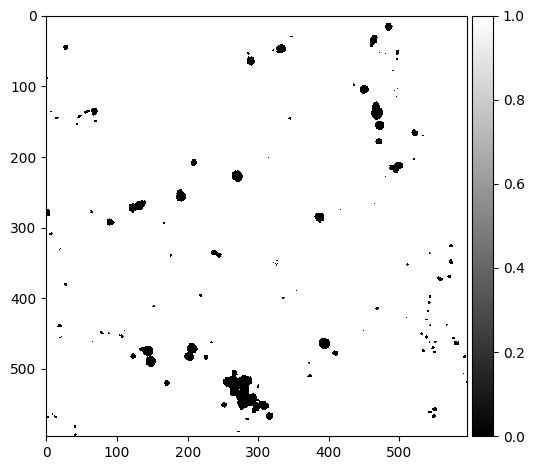

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_06.czi


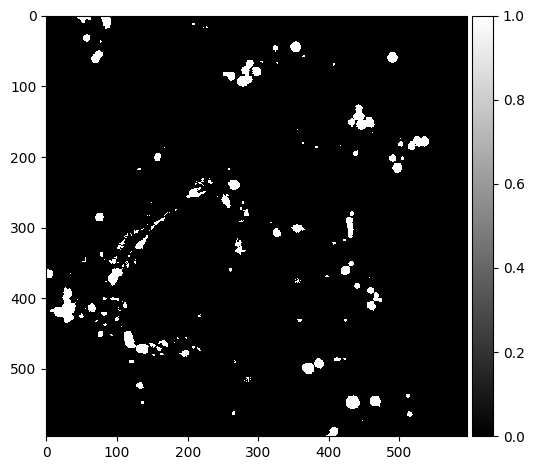

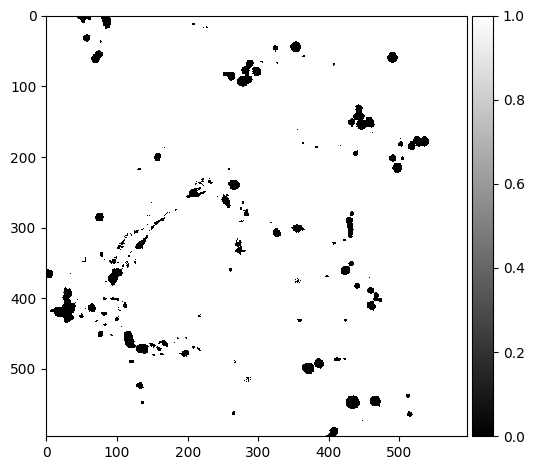

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_07.czi


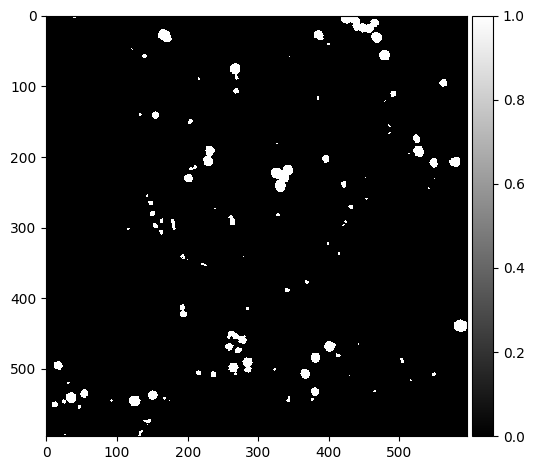

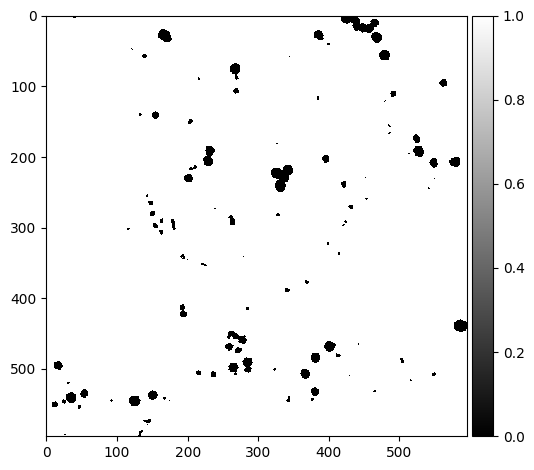

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_08.czi


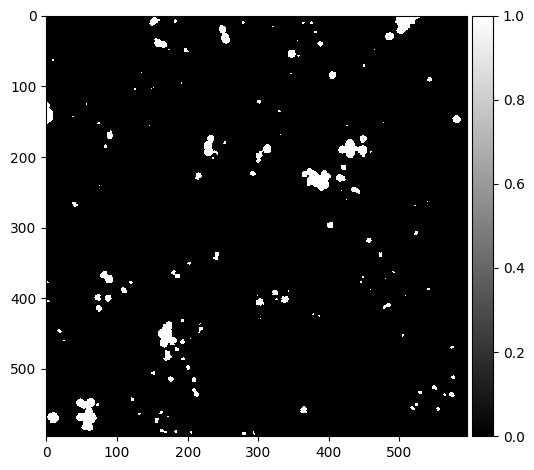

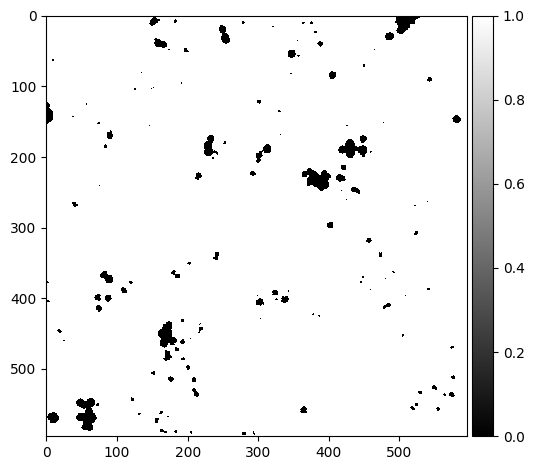

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_01.czi


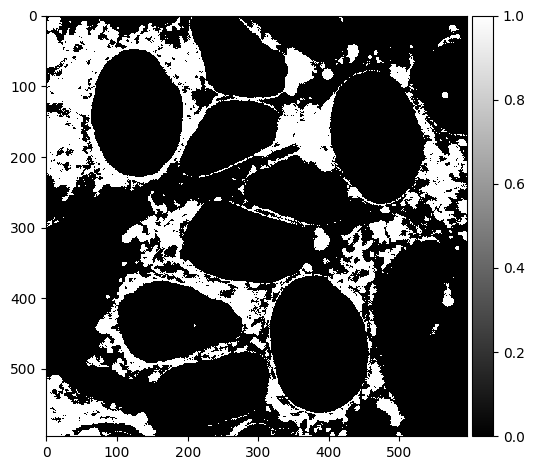

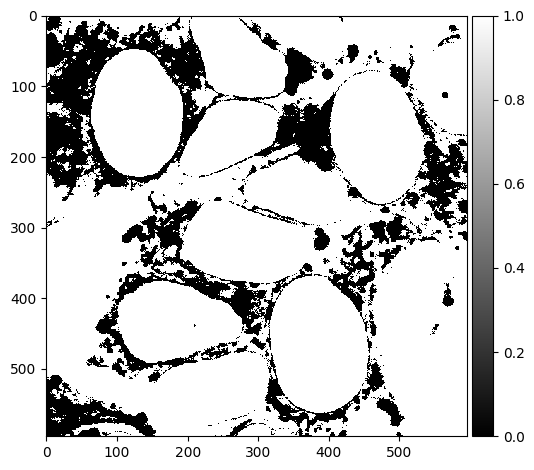

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_02.czi


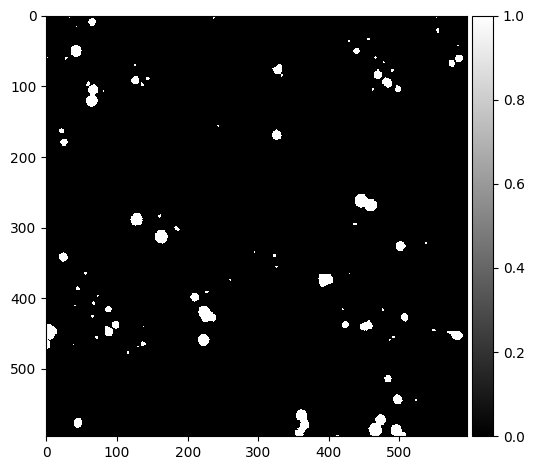

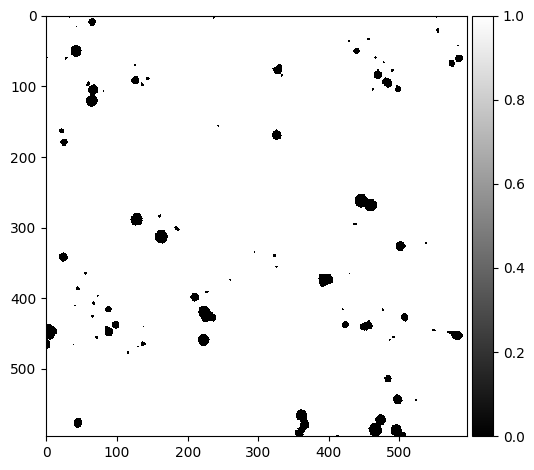

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_03.czi


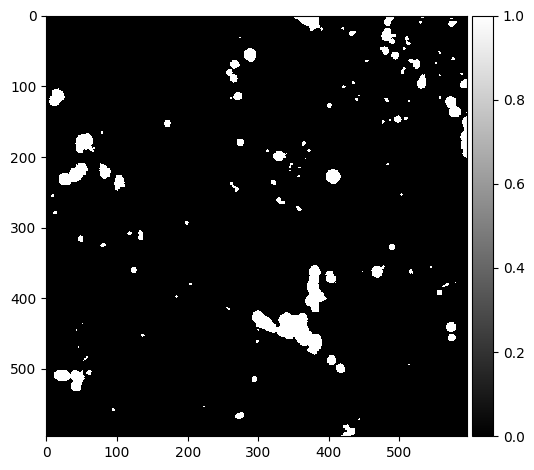

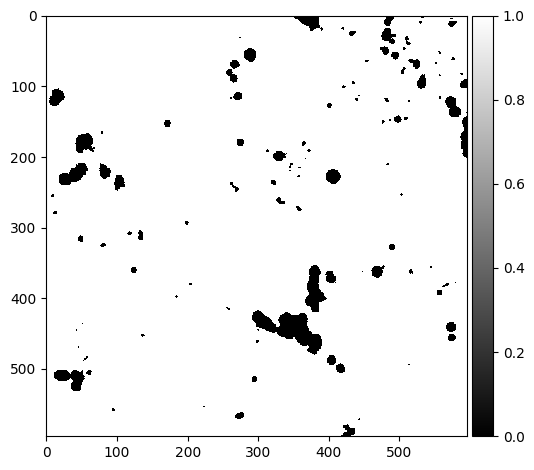

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_04.czi


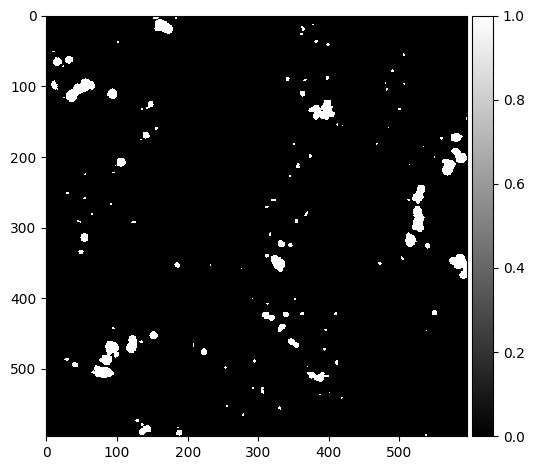

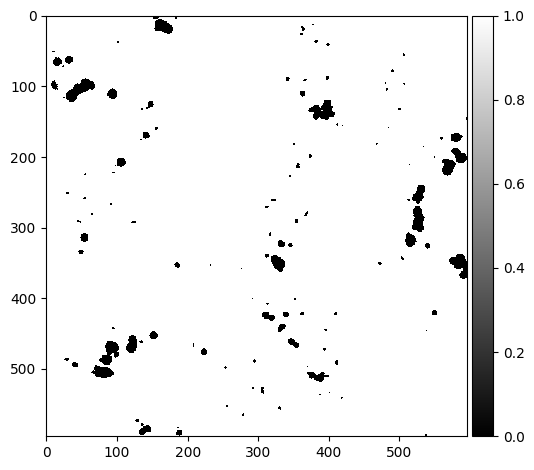

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_05.czi


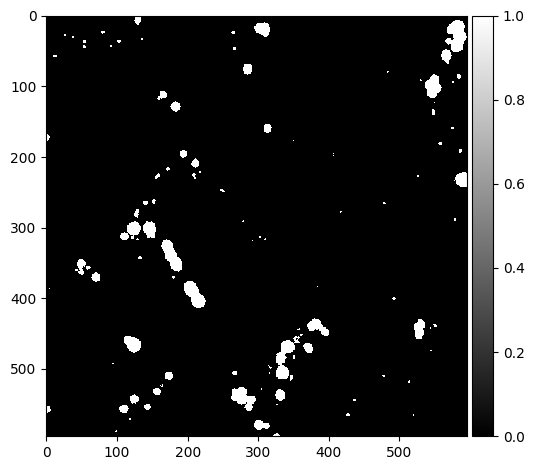

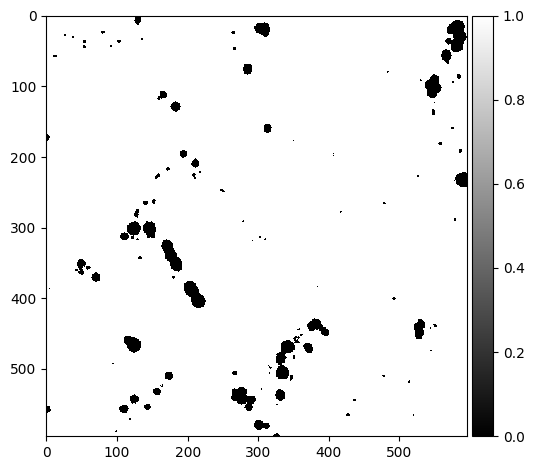

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_06.czi


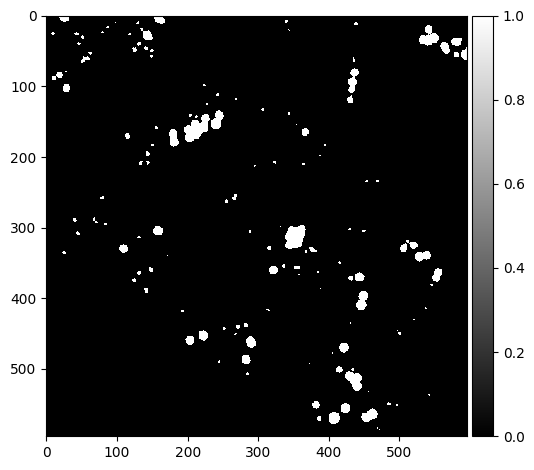

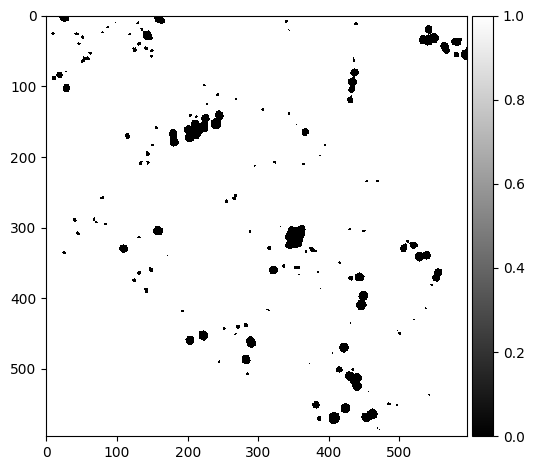

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_07.czi


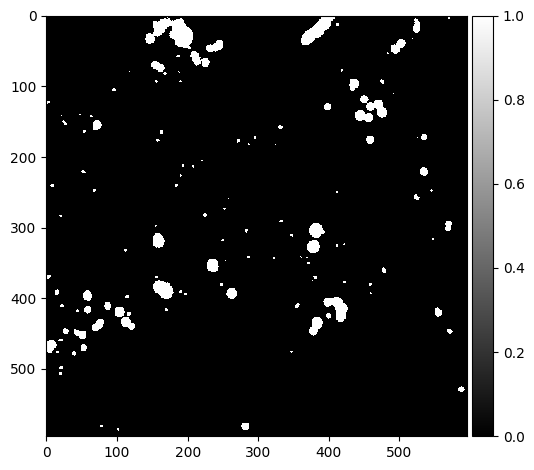

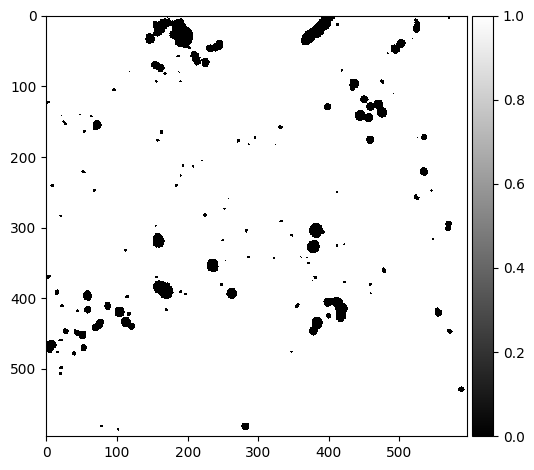

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_08.czi


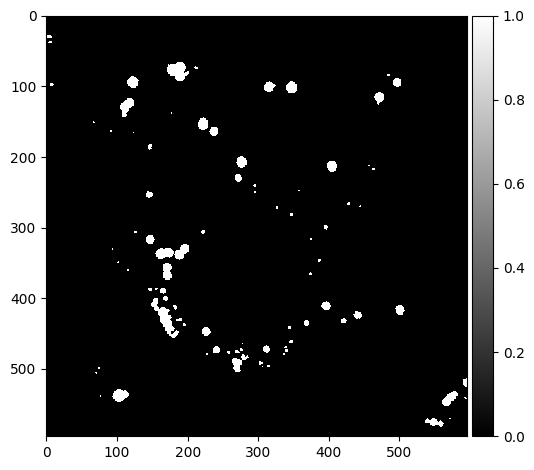

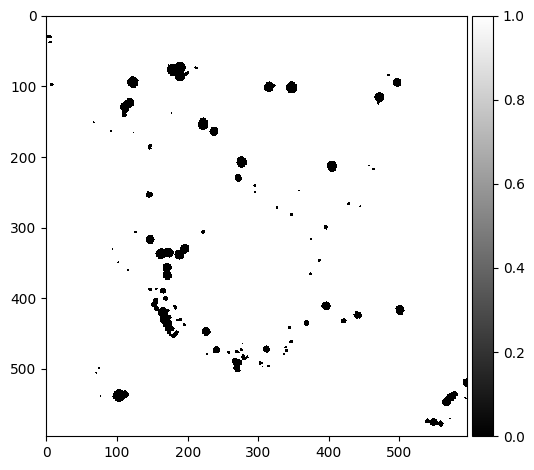

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_01.czi


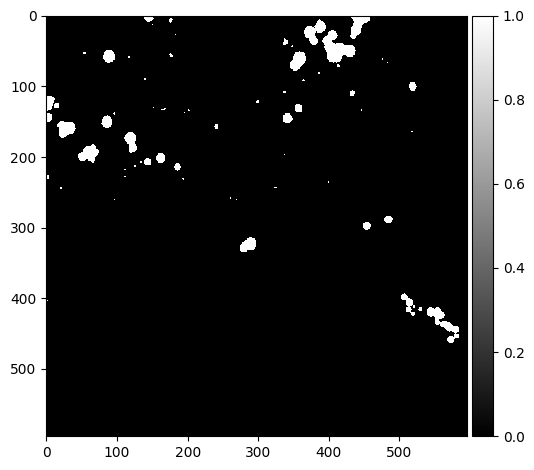

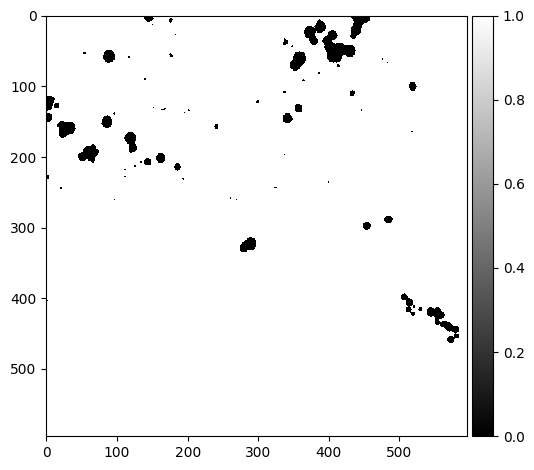

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_02.czi


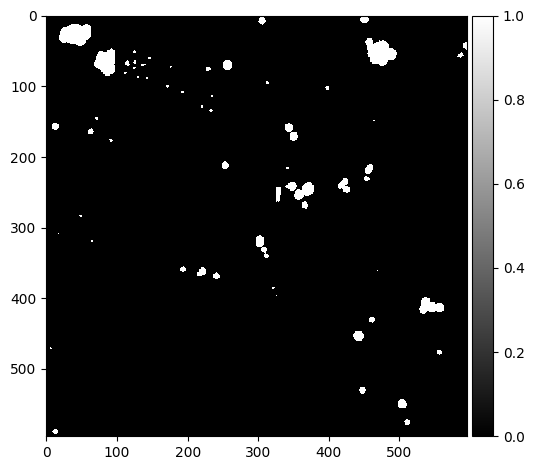

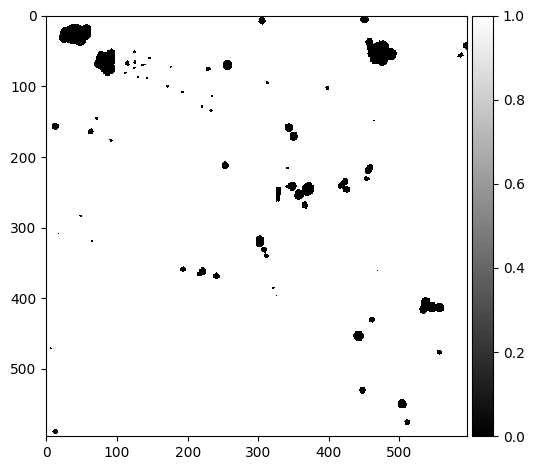

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_03.czi


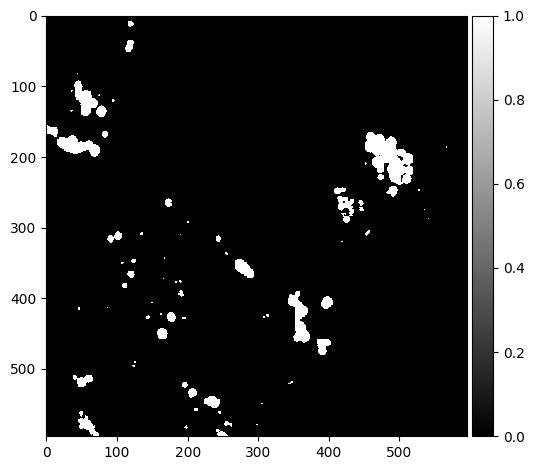

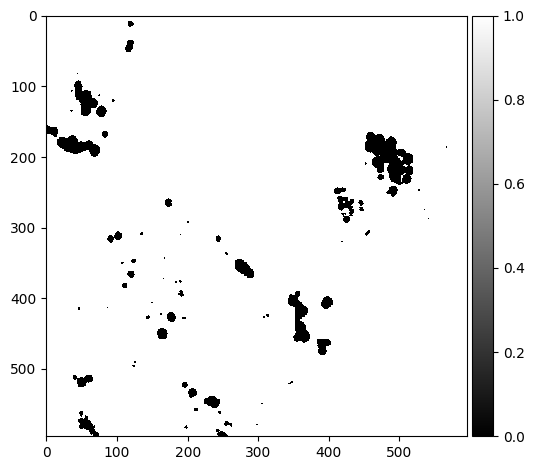

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_04.czi


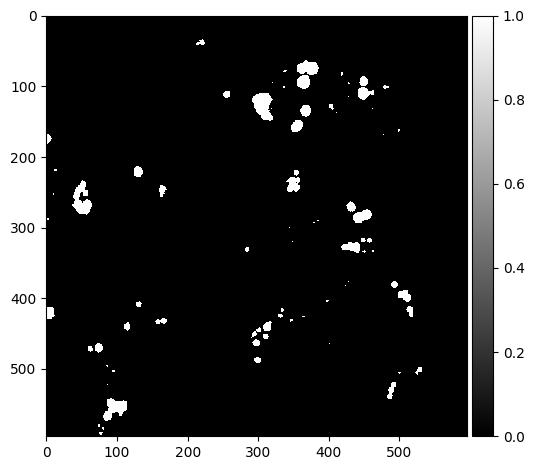

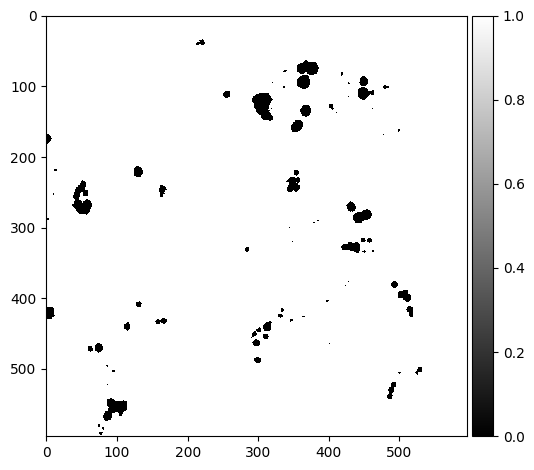

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_05.czi


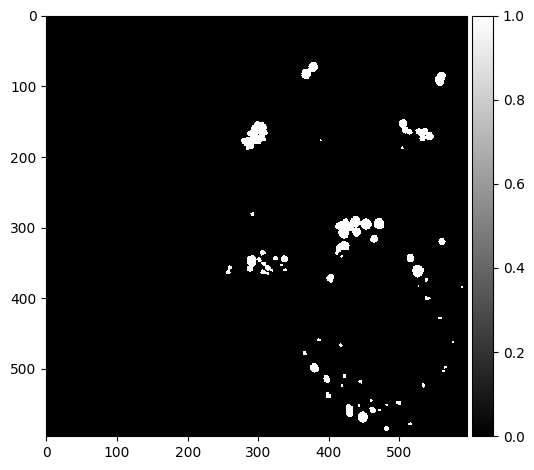

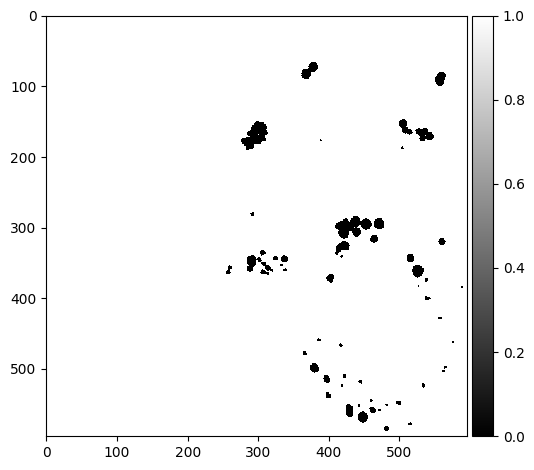

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_06.czi


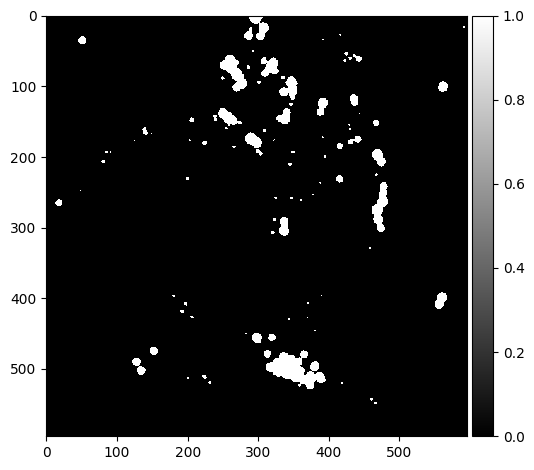

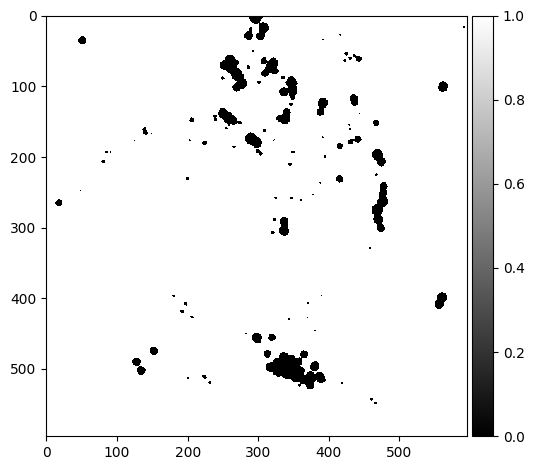

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_07.czi


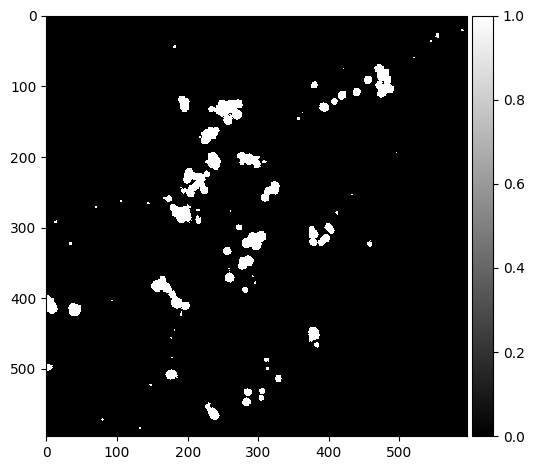

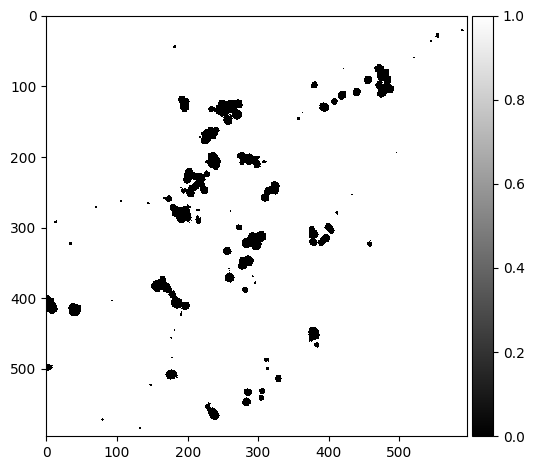

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_08.czi


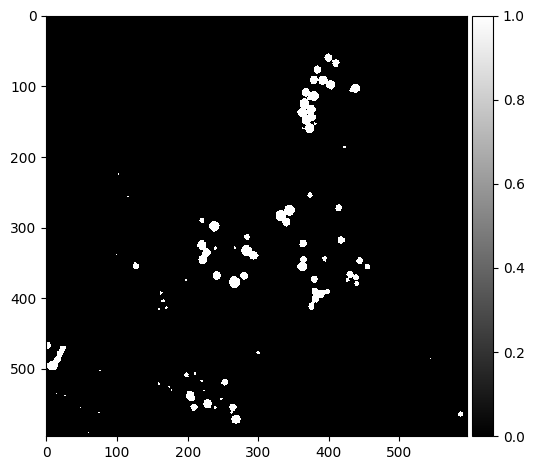

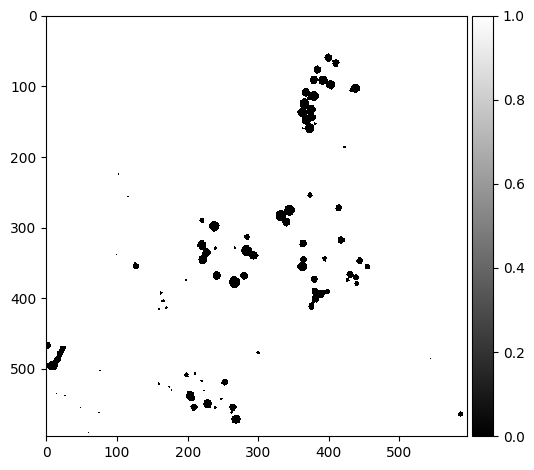

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_01.czi


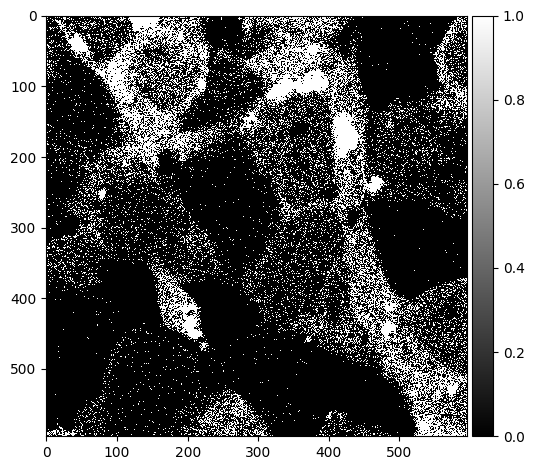

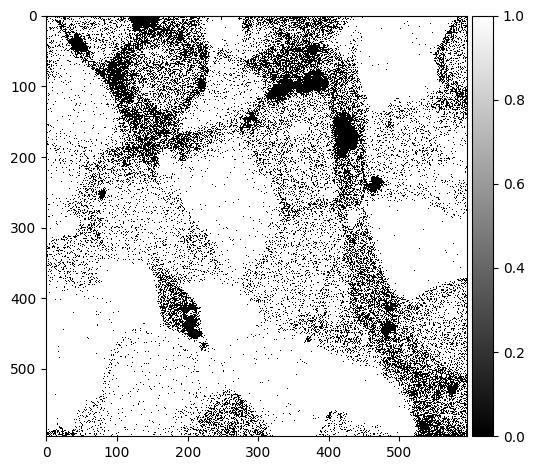

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_02.czi


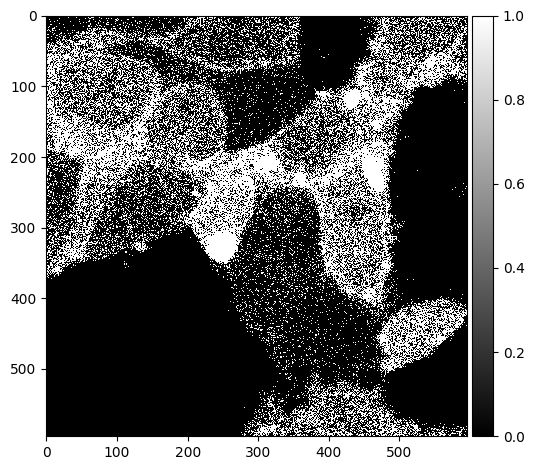

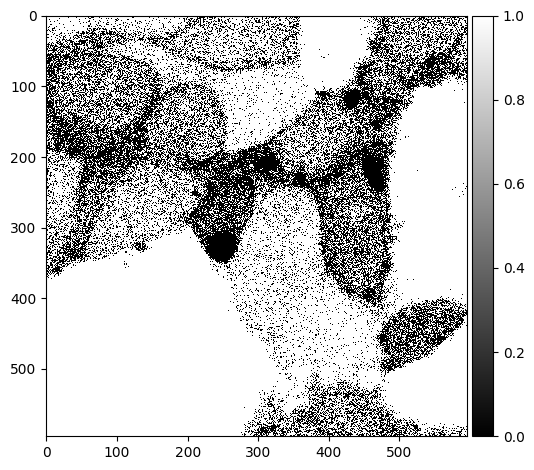

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_03.czi


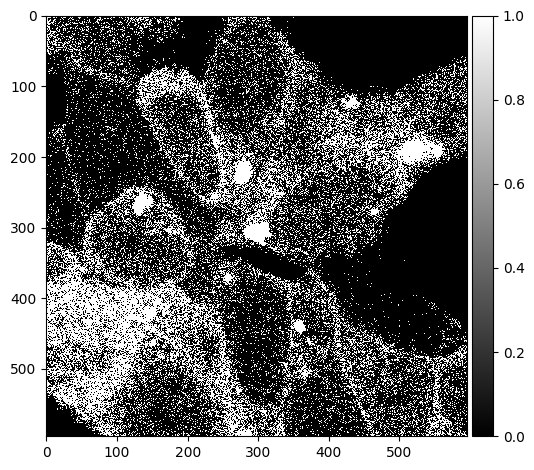

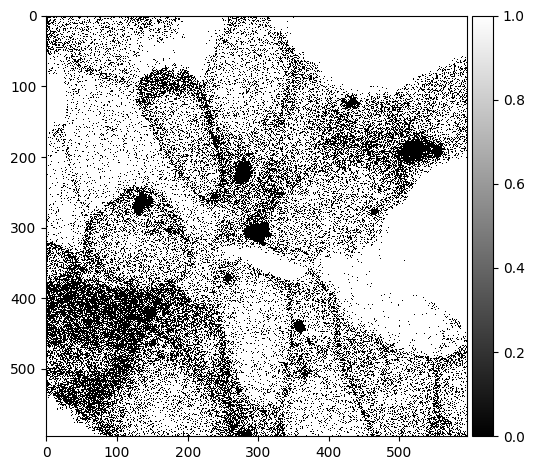

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_04.czi


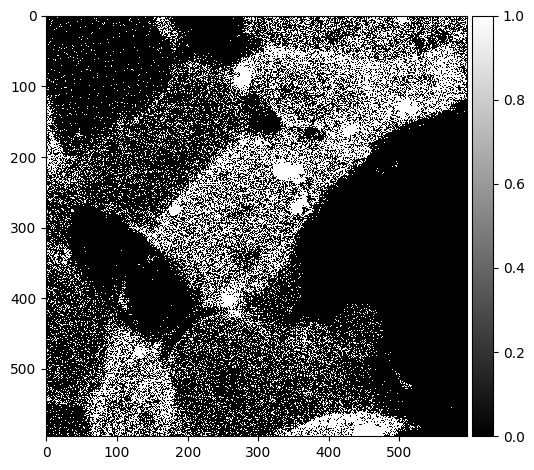

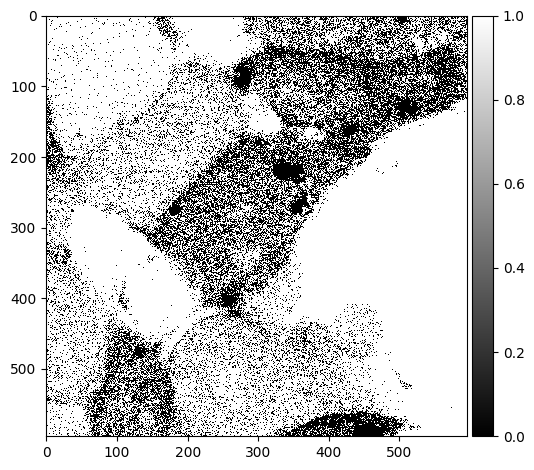

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_05.czi


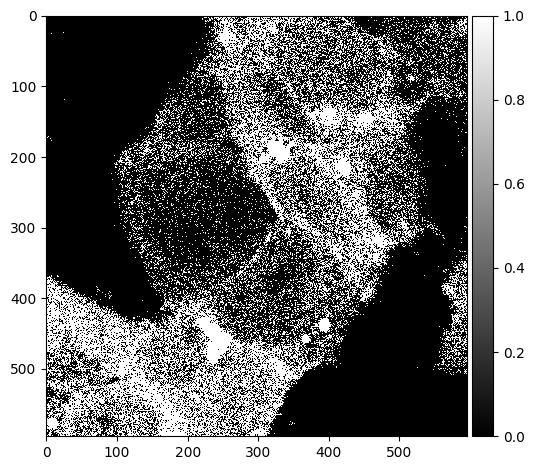

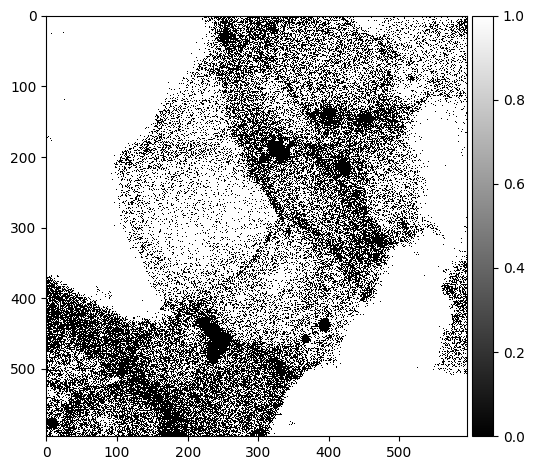

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_06.czi


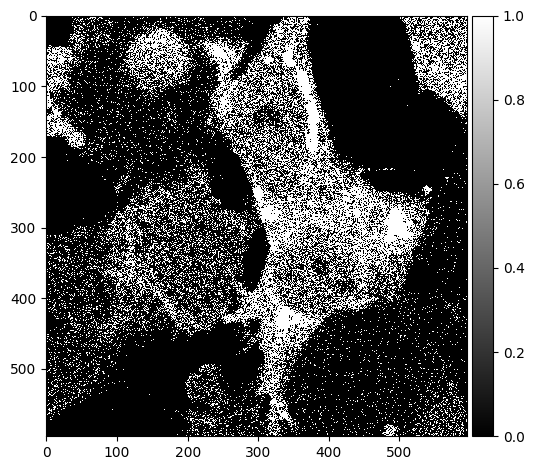

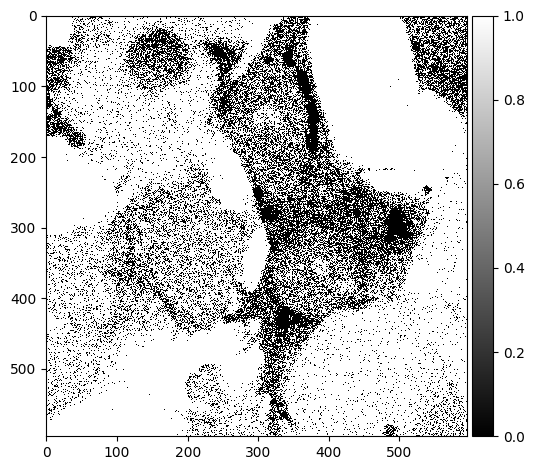

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_07.czi


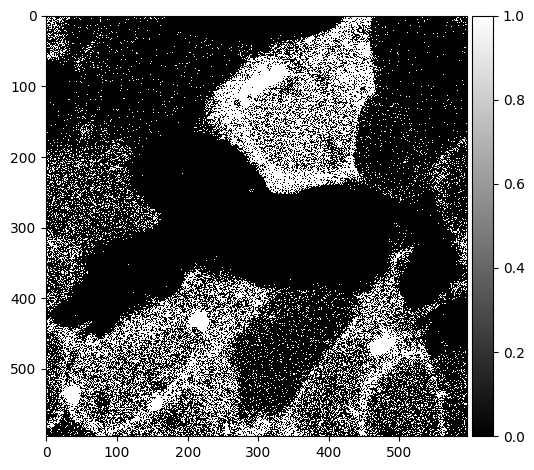

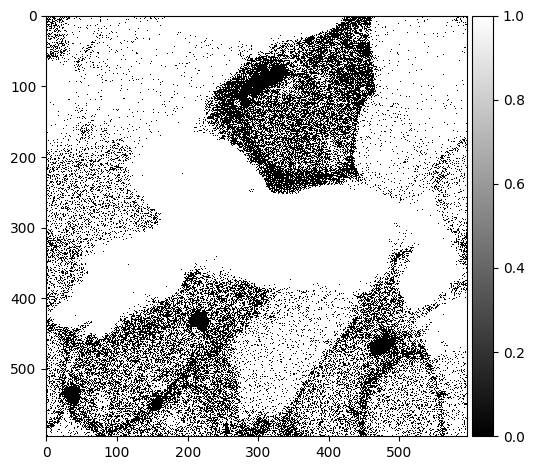

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_08.czi


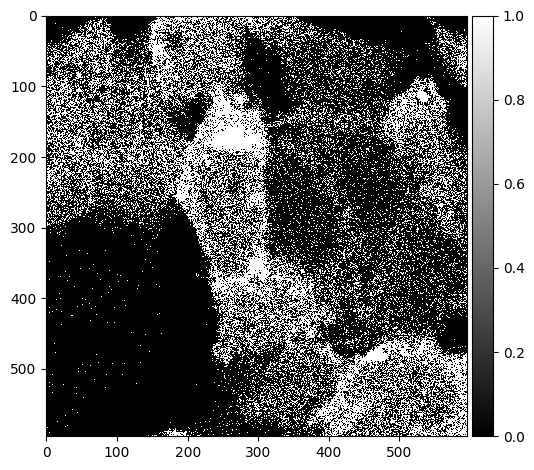

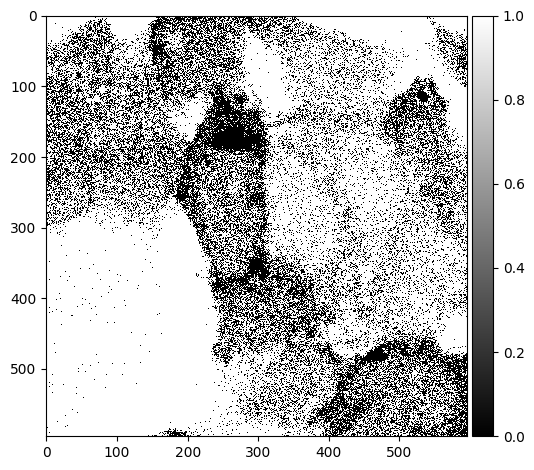

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_01.czi


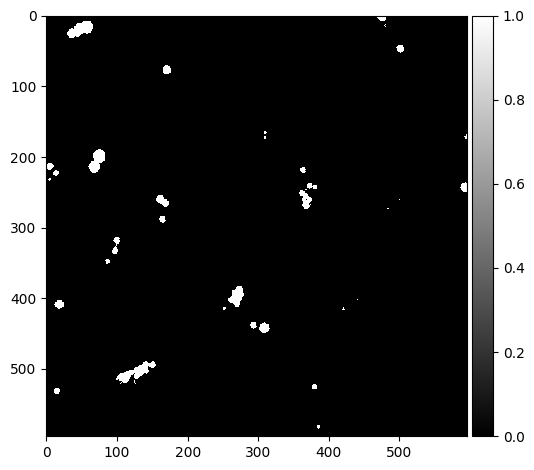

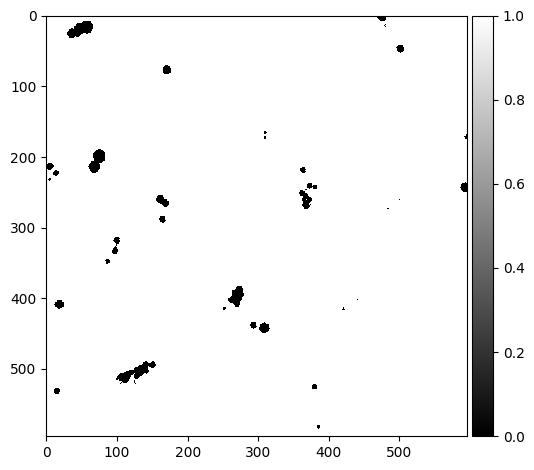

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_02.czi


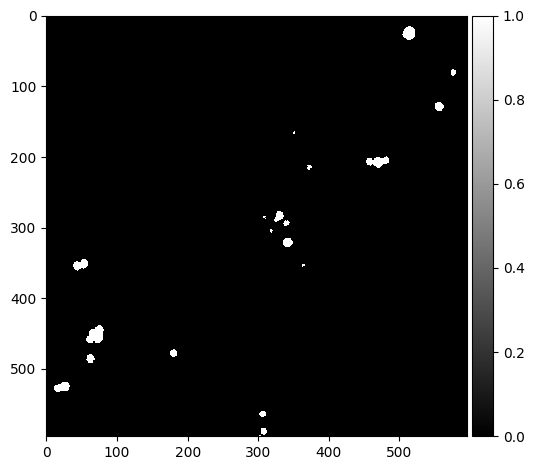

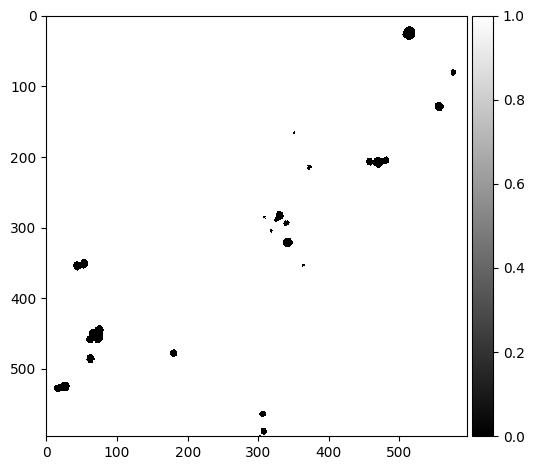

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_03.czi


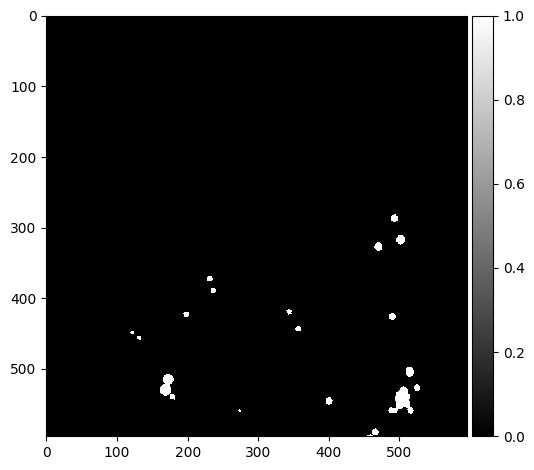

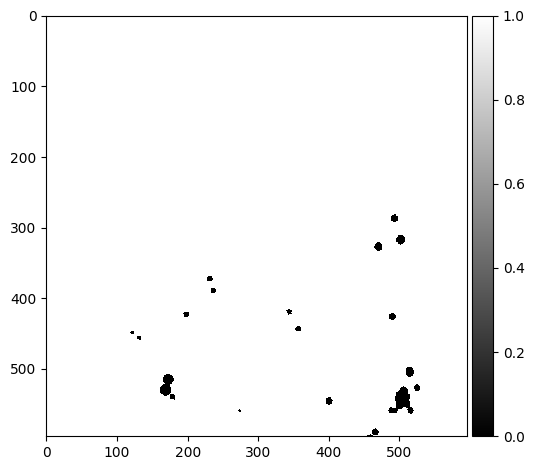

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_04.czi


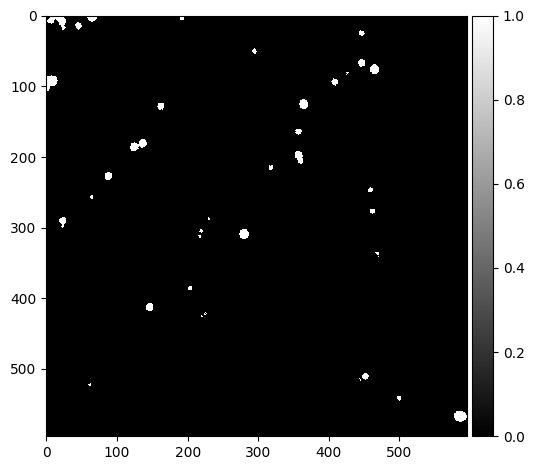

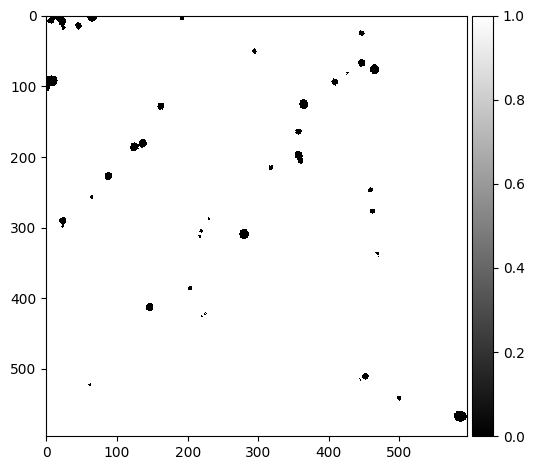

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_05.czi


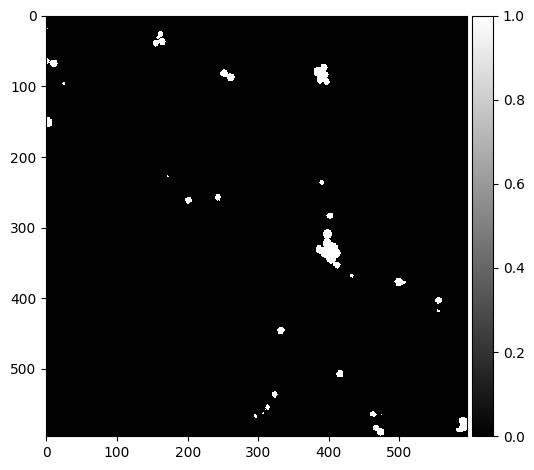

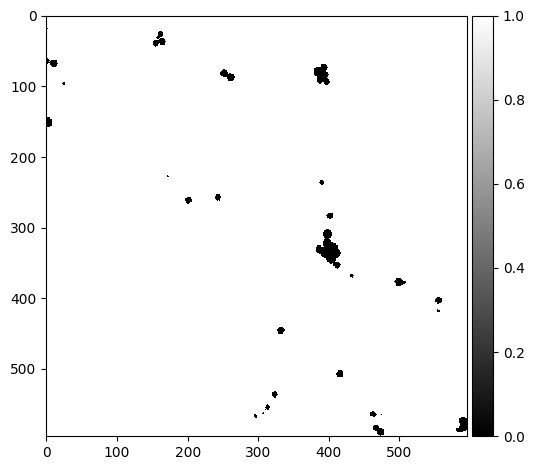

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_06.czi


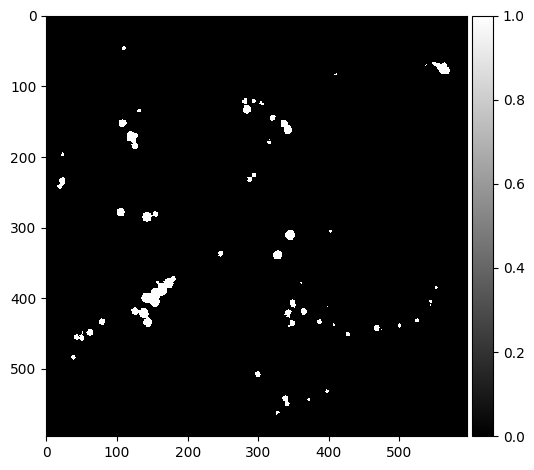

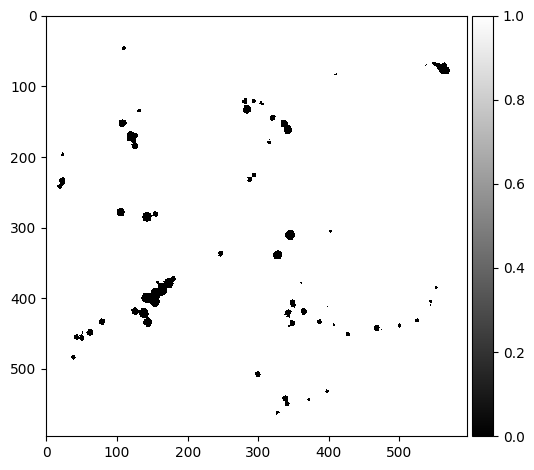

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_07.czi


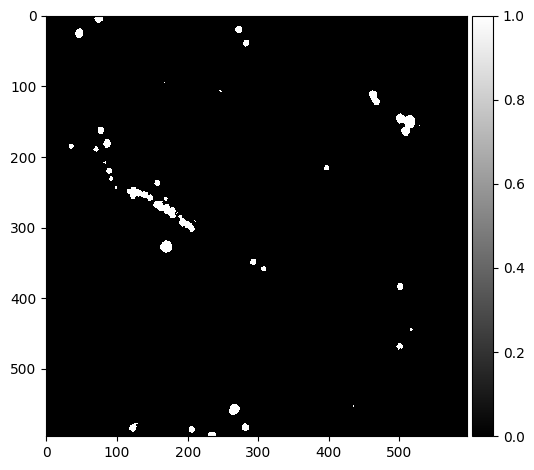

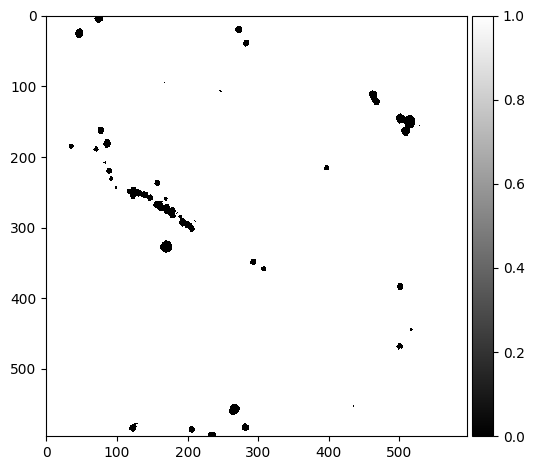

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_08.czi


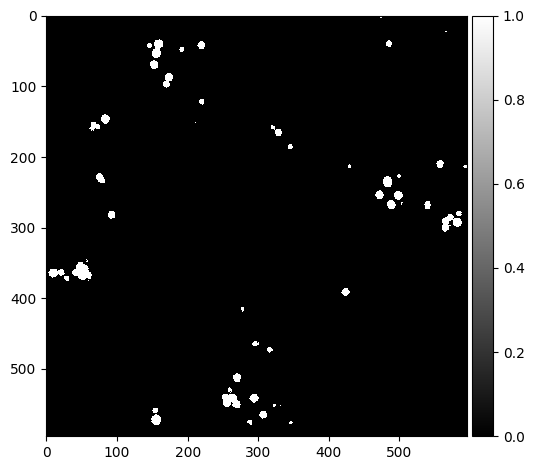

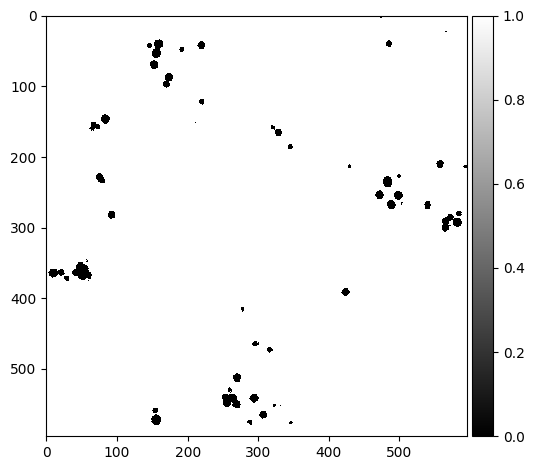

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_01.czi


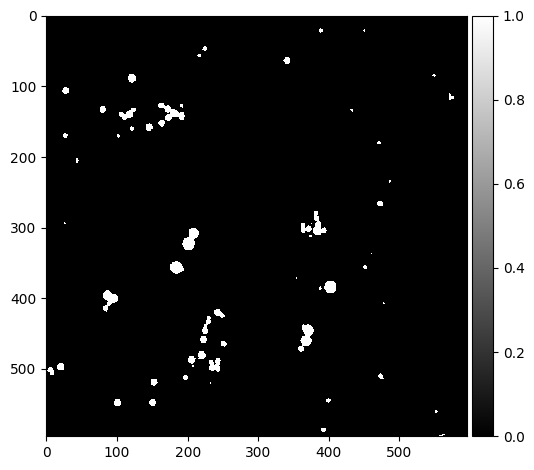

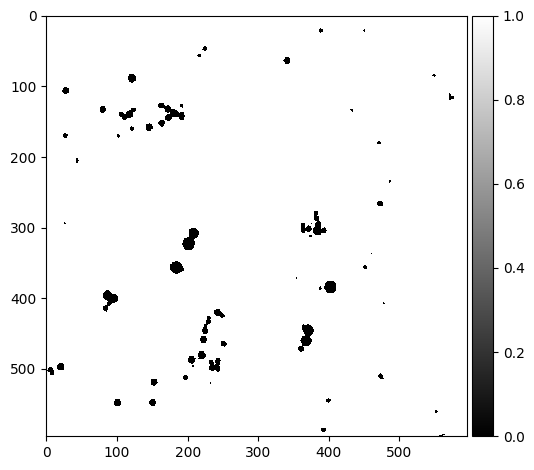

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_02.czi


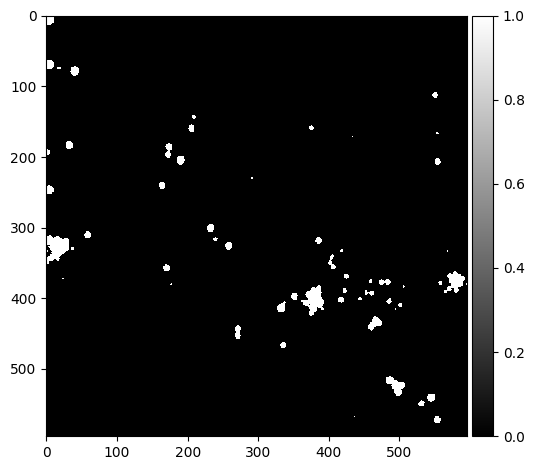

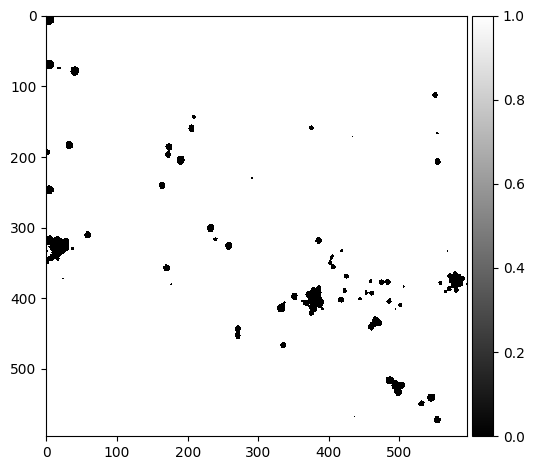

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_03.czi


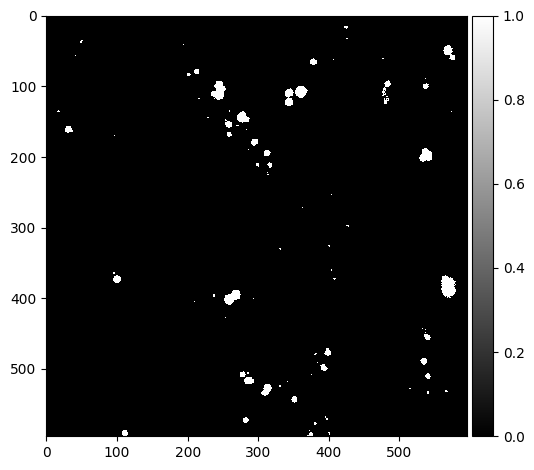

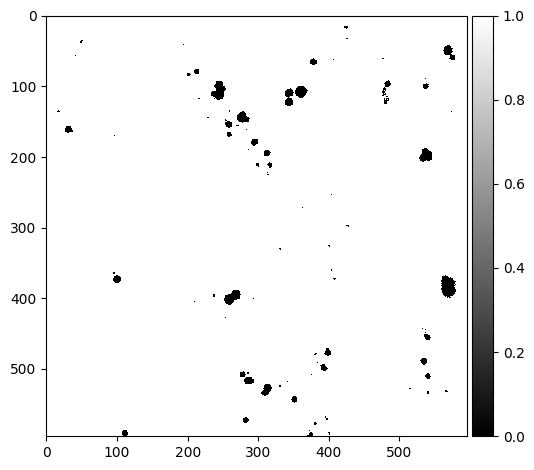

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_04.czi


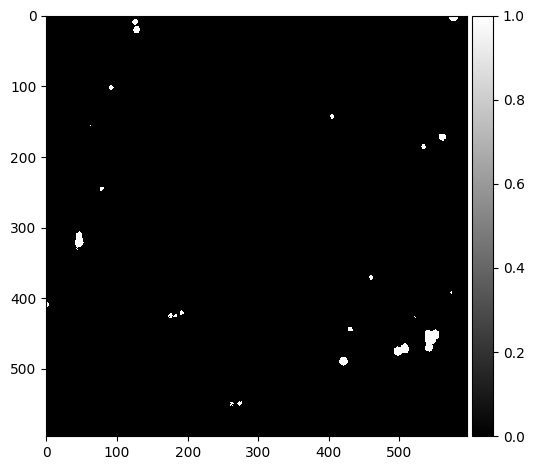

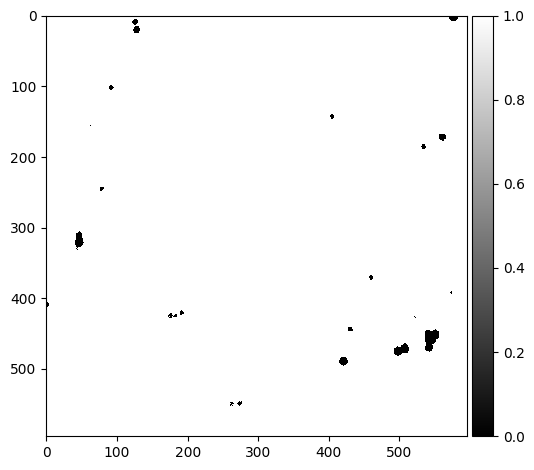

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_05.czi


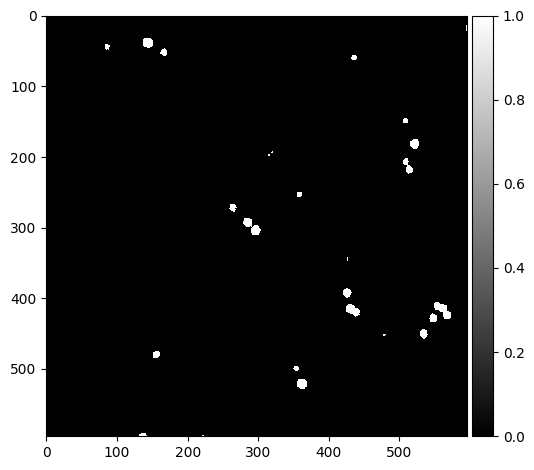

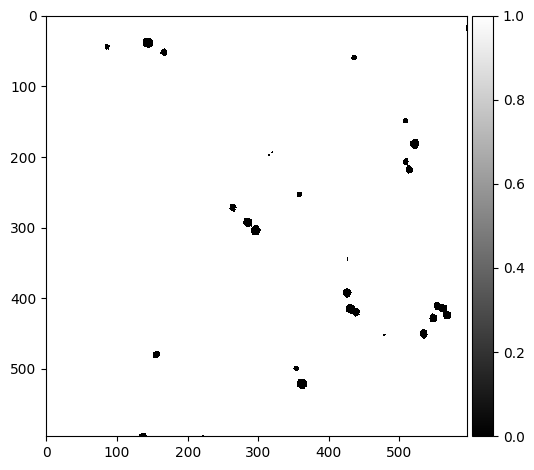

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_06.czi


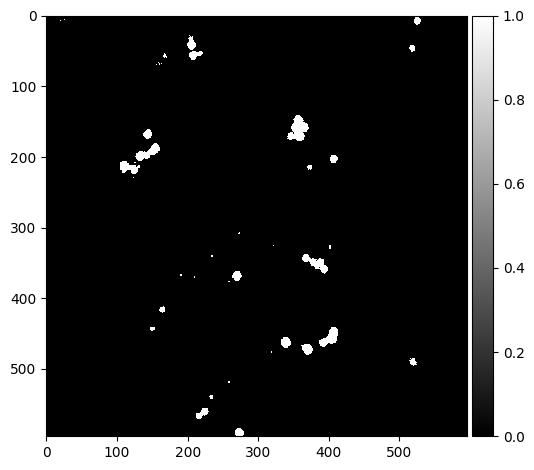

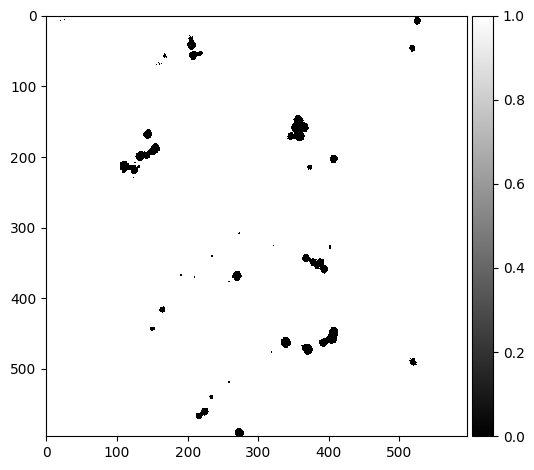

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_07.czi


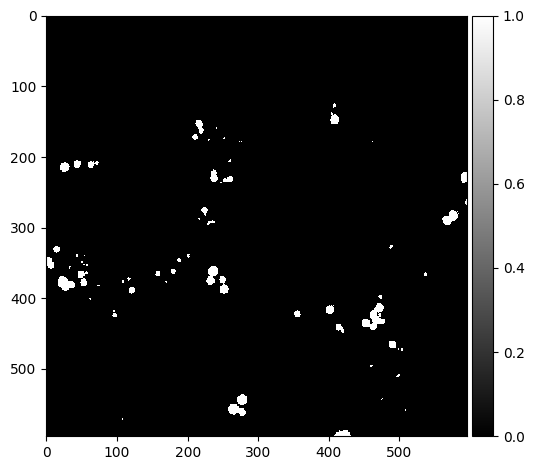

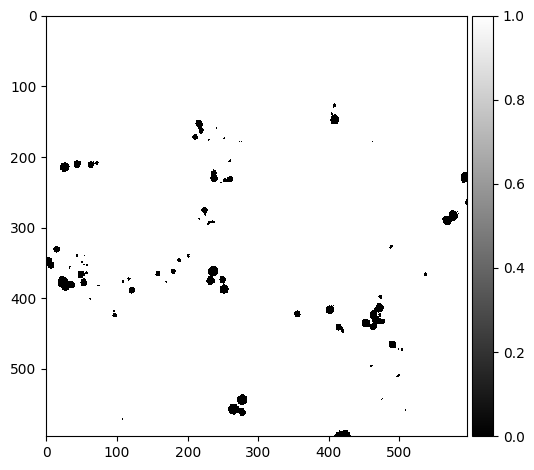

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_08.czi


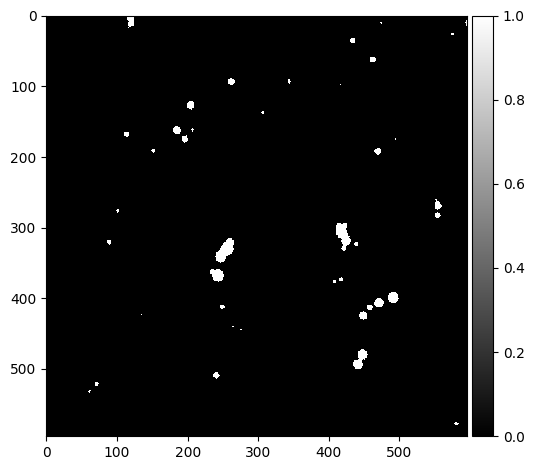

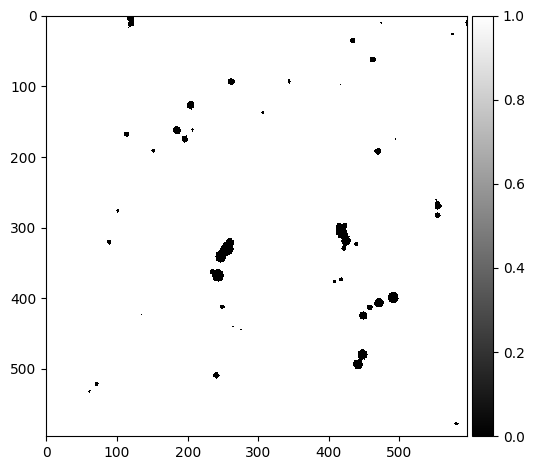

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_01.czi


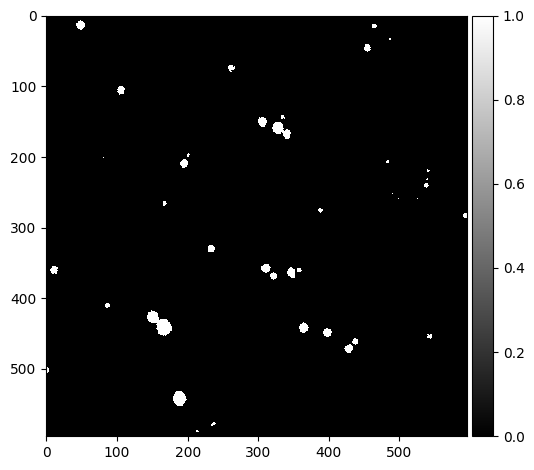

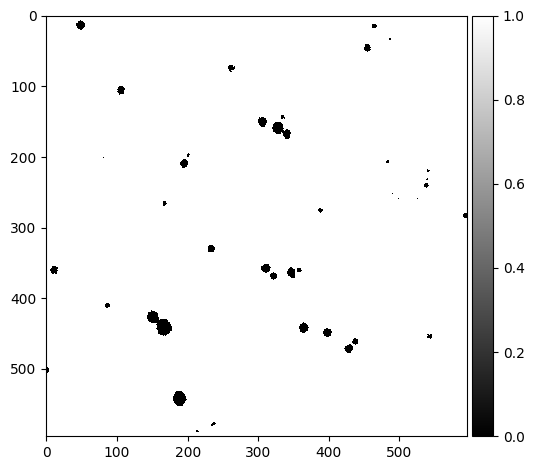

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_02.czi


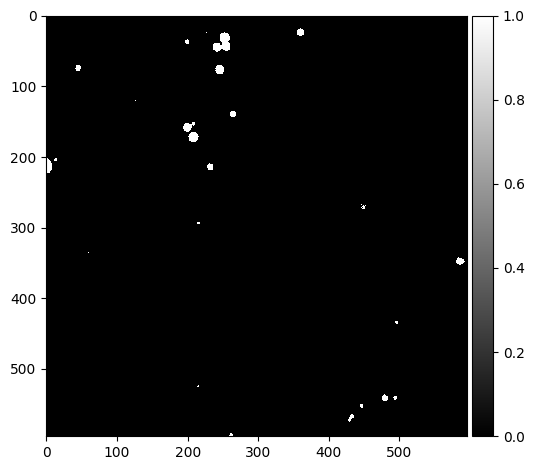

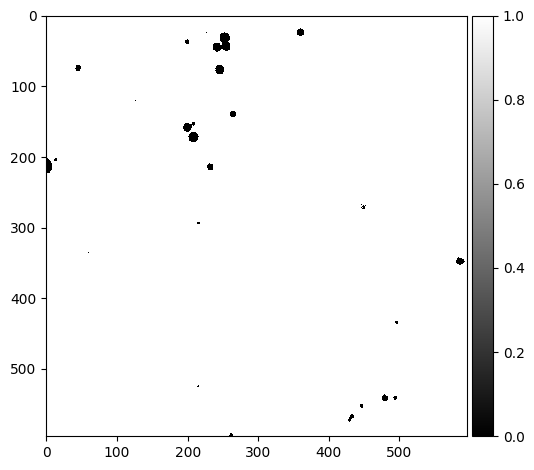

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_03.czi


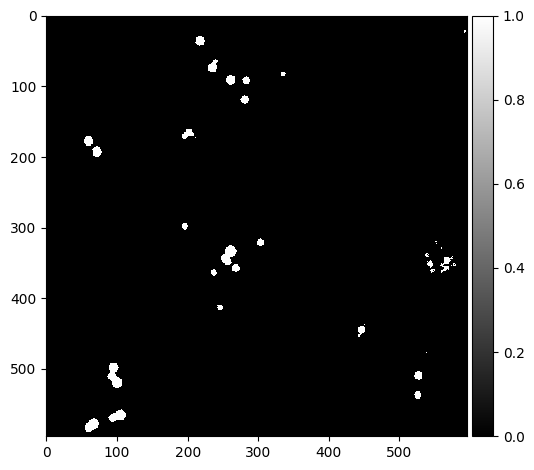

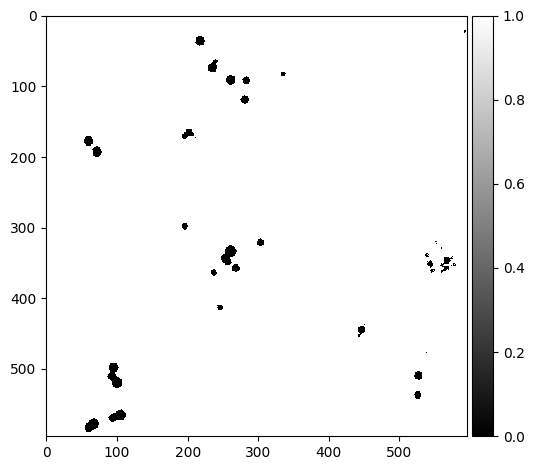

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_04.czi


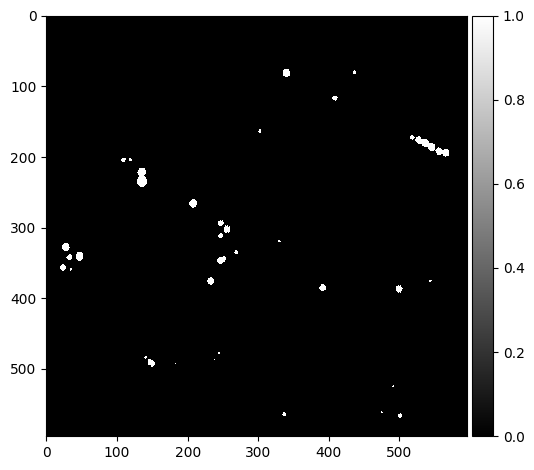

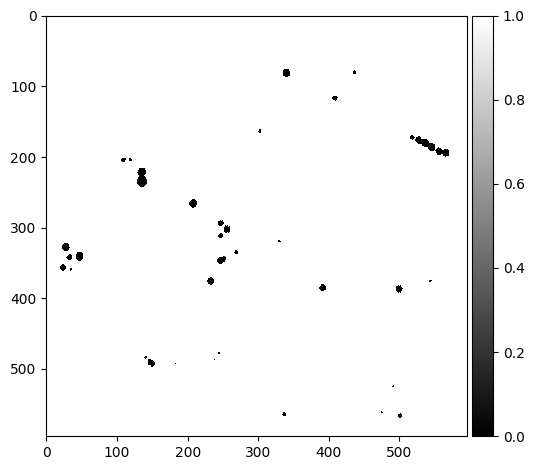

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_05.czi


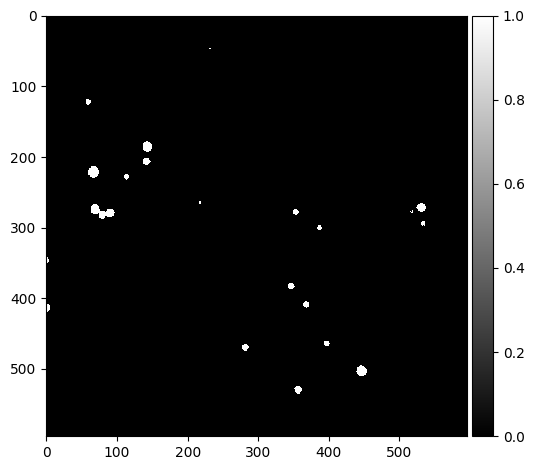

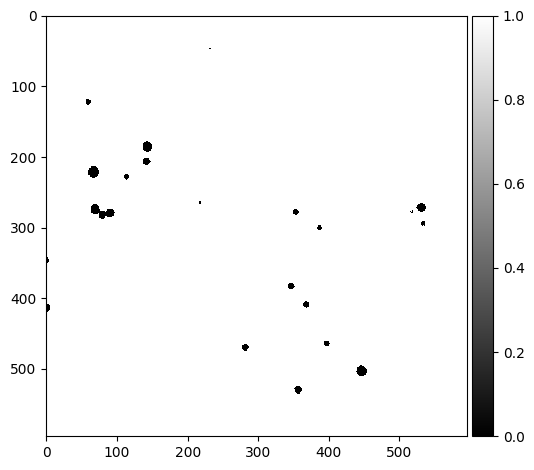

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_06.czi


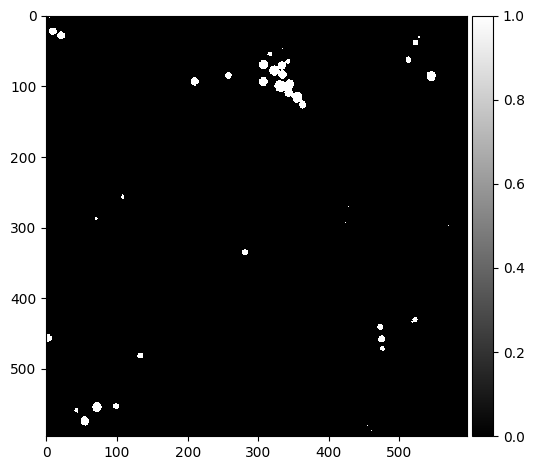

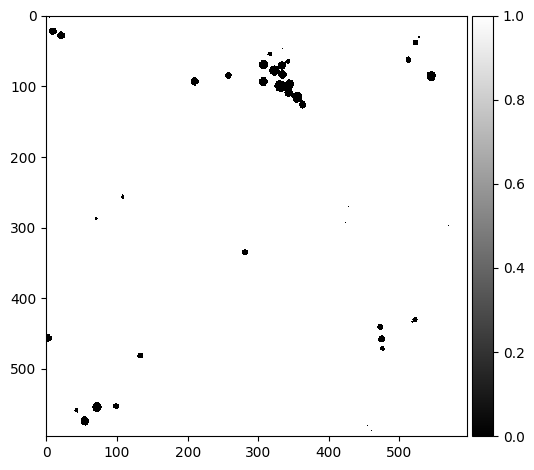

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_07.czi


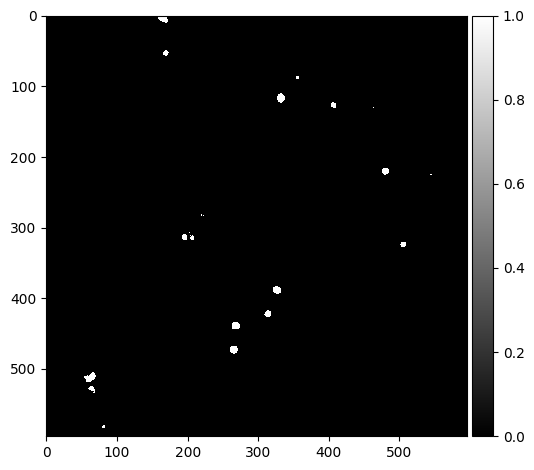

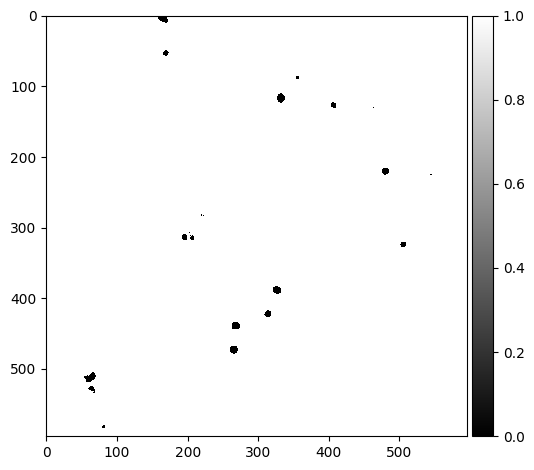

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_08.czi


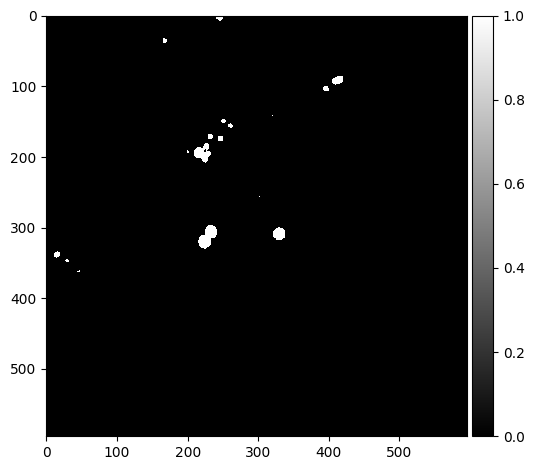

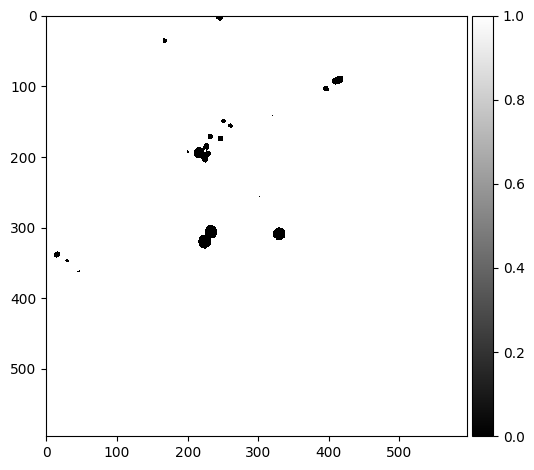

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_01.czi


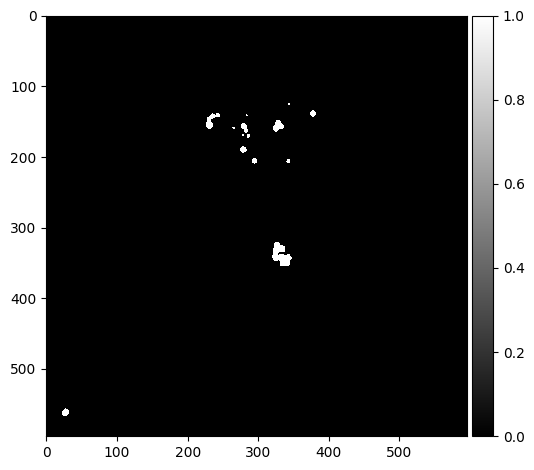

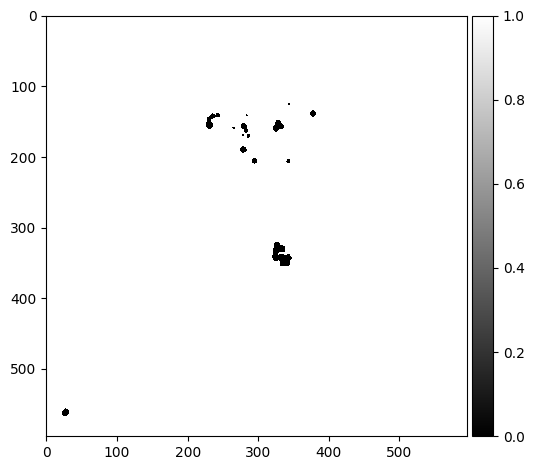

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_02.czi


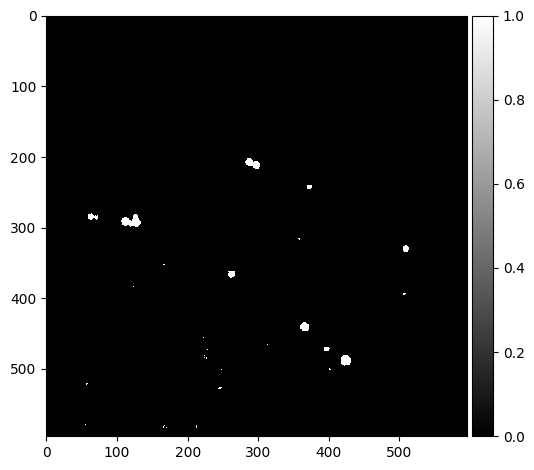

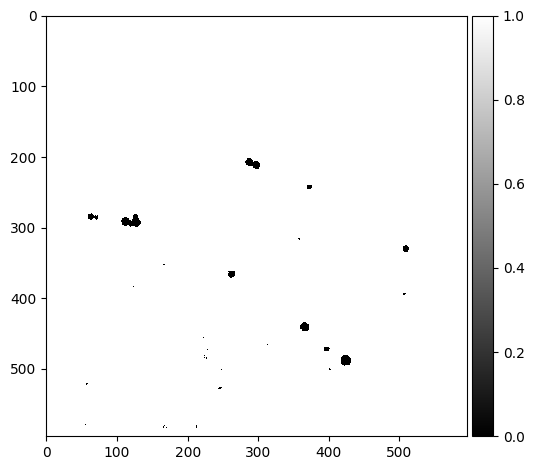

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_03.czi


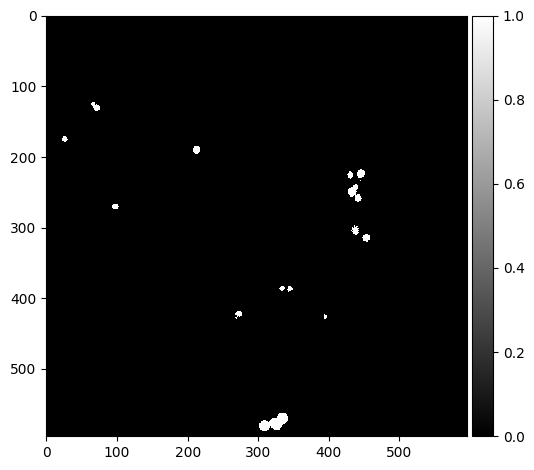

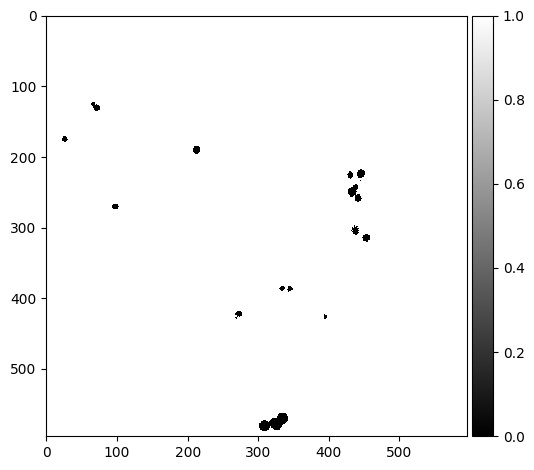

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_04.czi


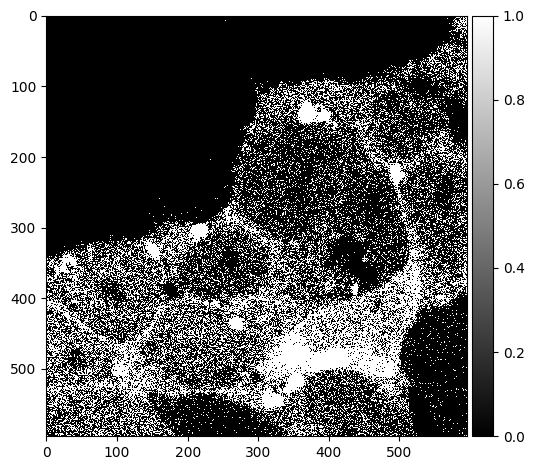

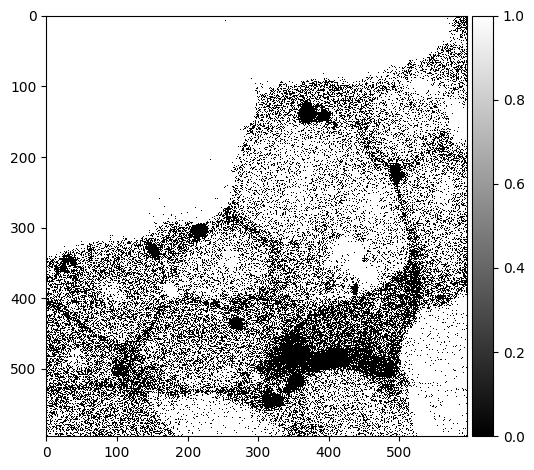

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_05.czi


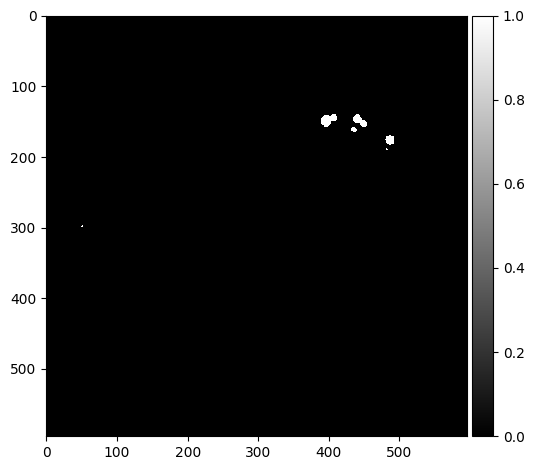

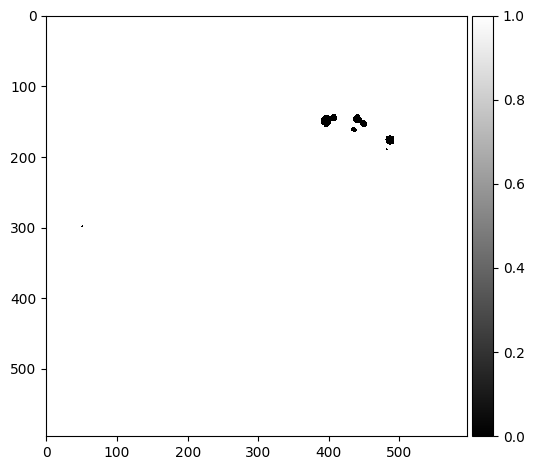

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_06.czi


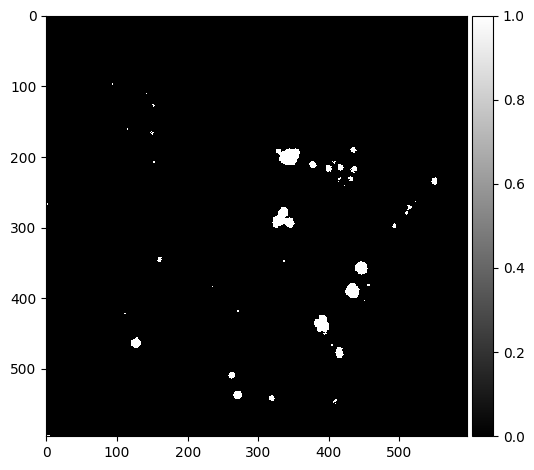

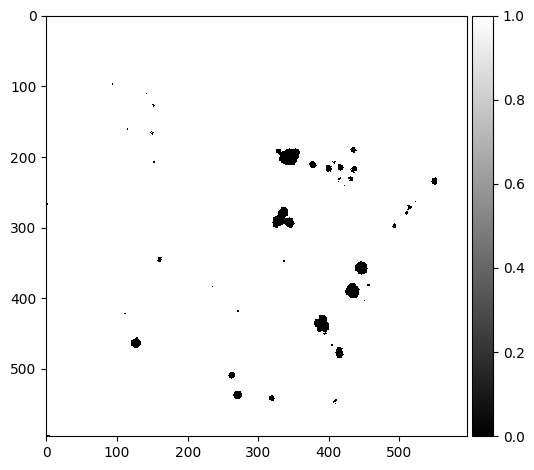

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_07.czi


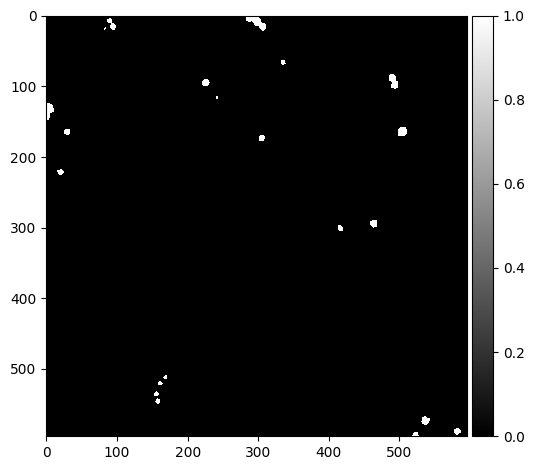

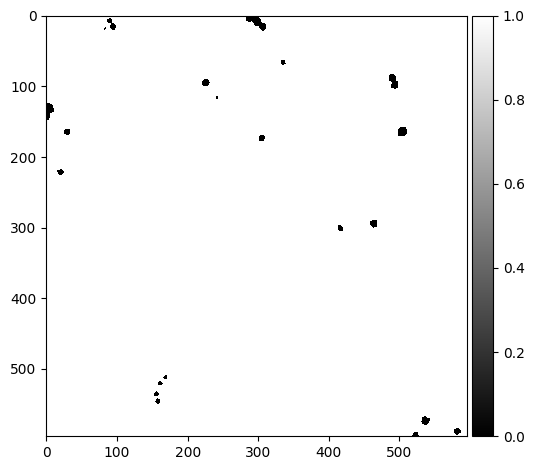

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Dox_conventional_image_08.czi


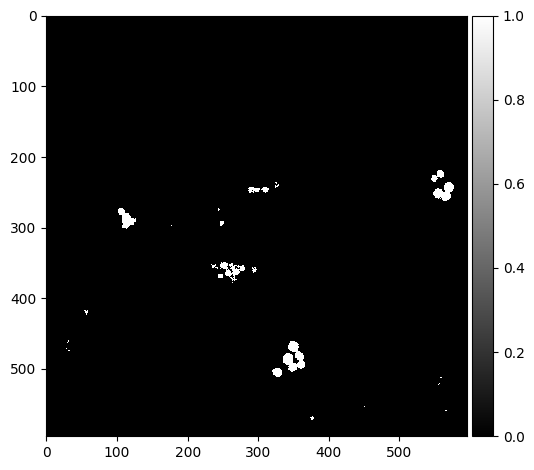

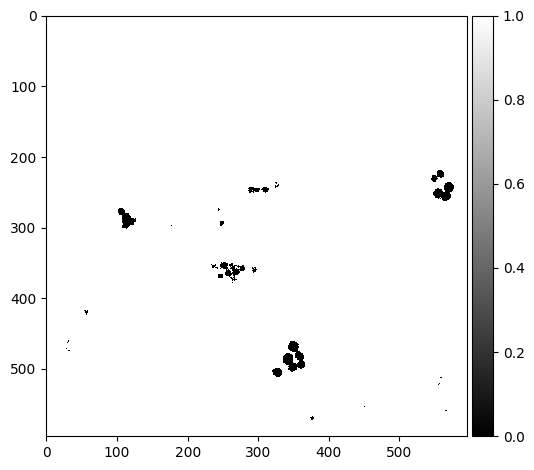

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_01.czi


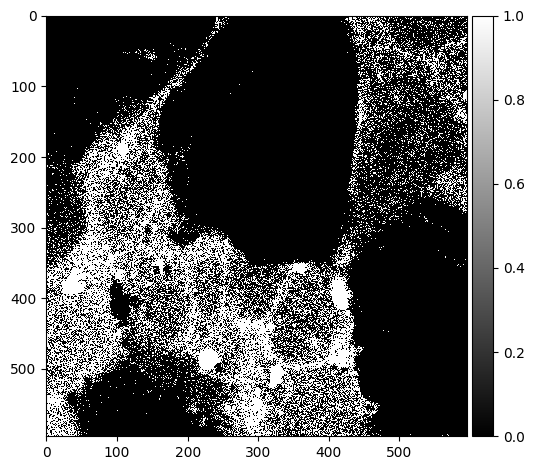

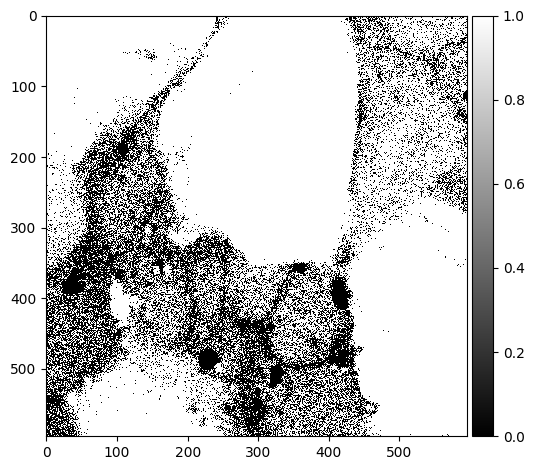

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_02.czi


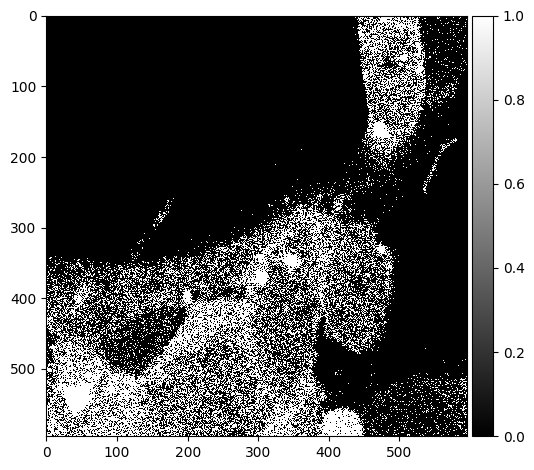

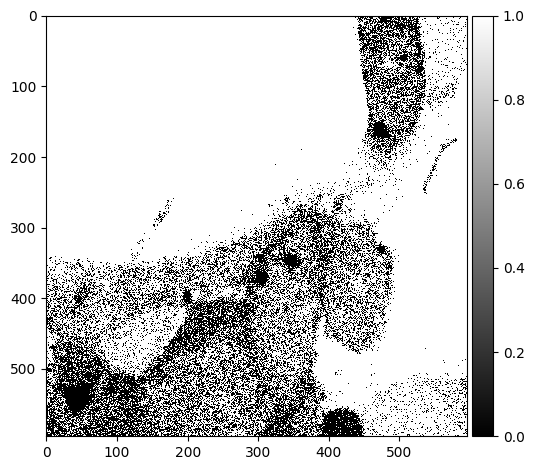

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_03.czi


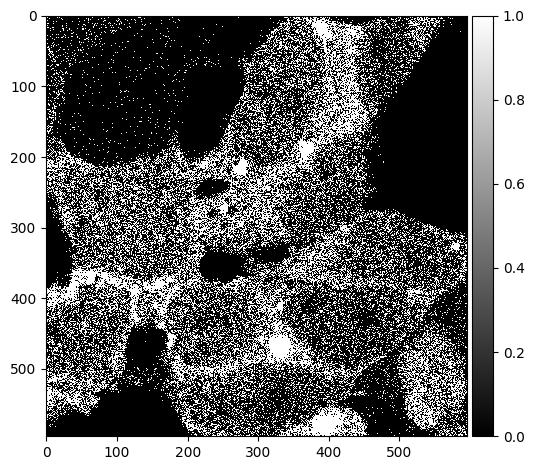

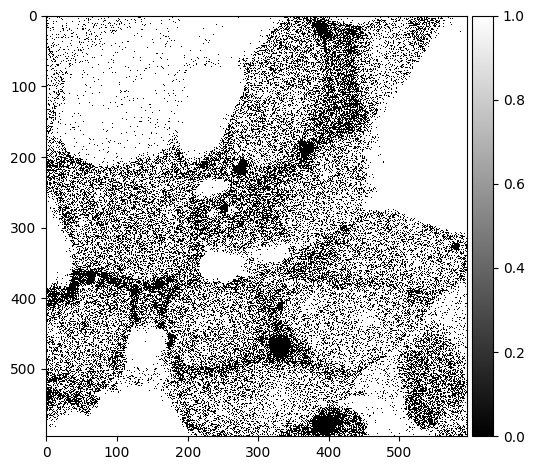

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_04.czi


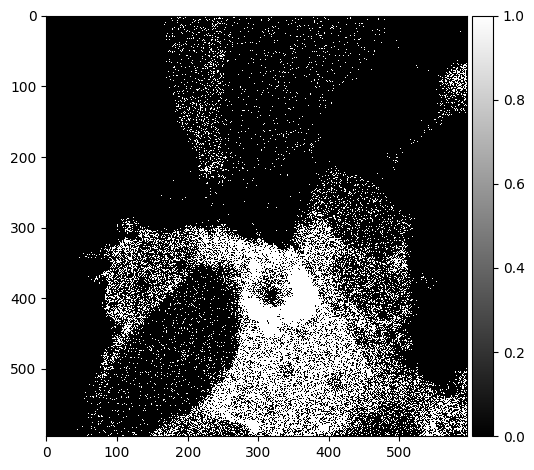

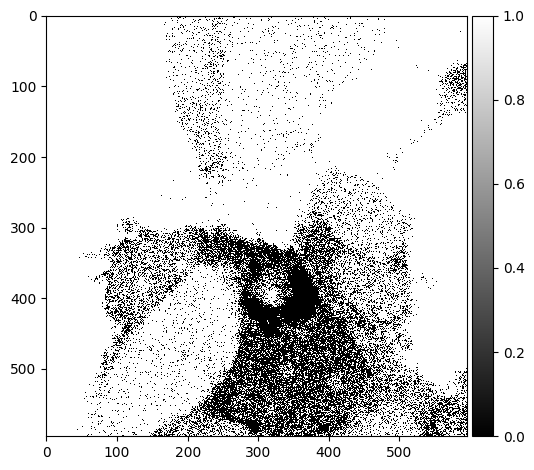

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_05.czi


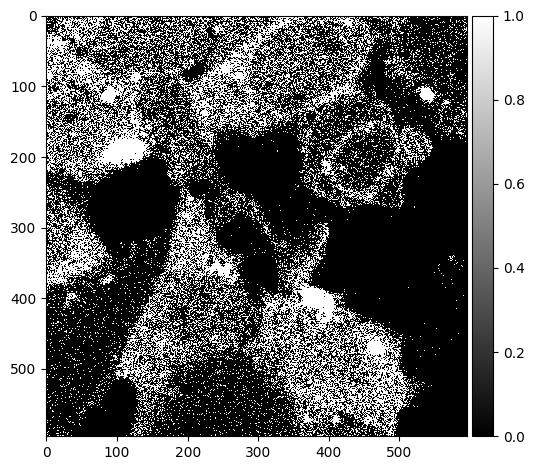

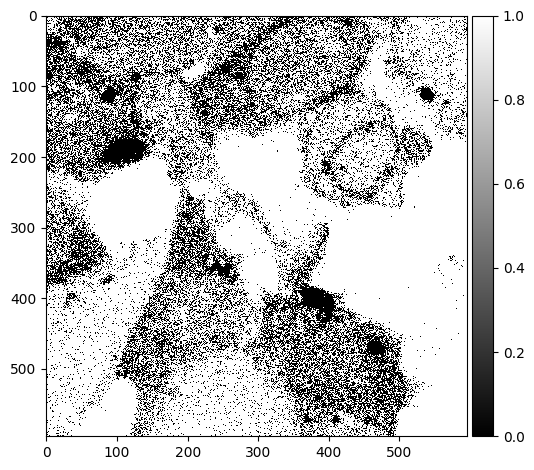

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_06.czi


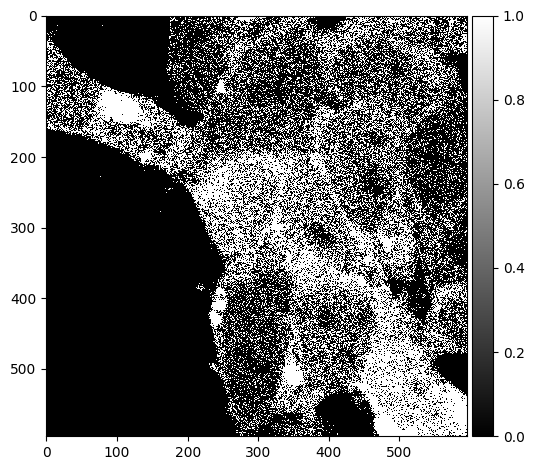

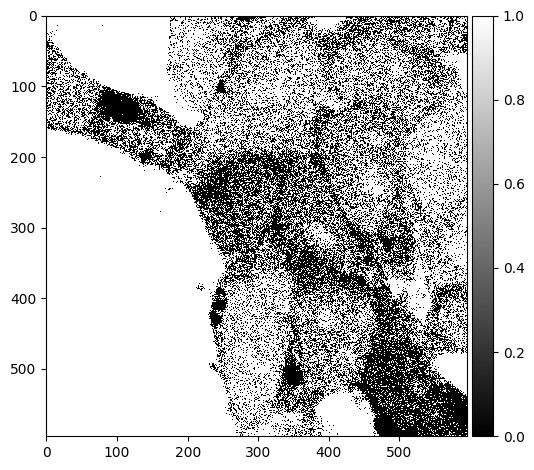

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_07.czi


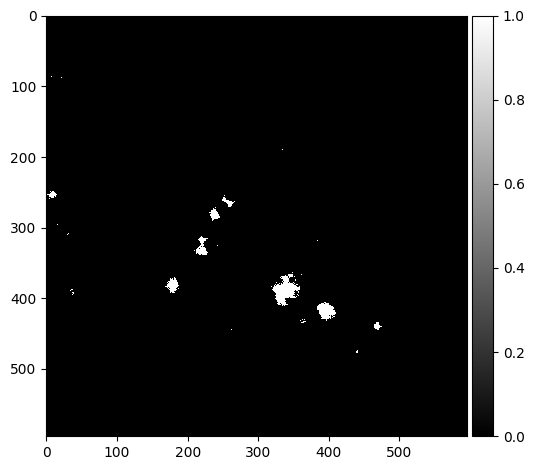

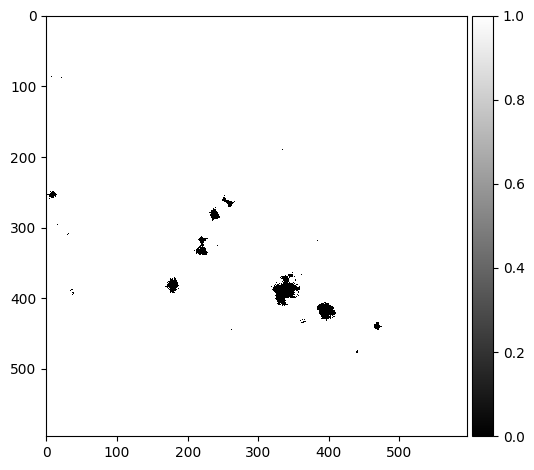

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dox_conventional_image_08.czi


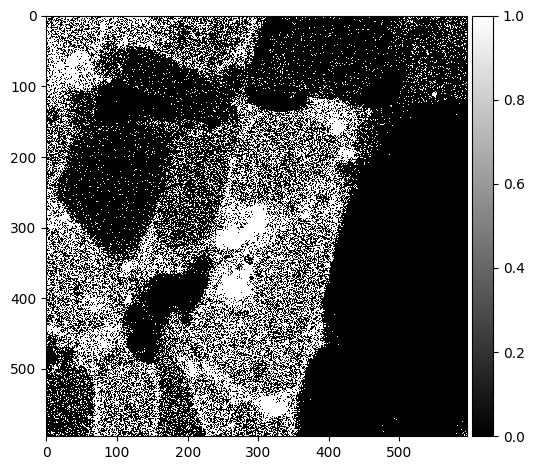

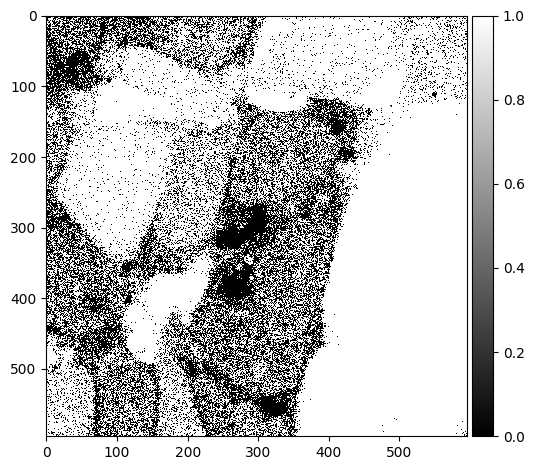

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_01.czi


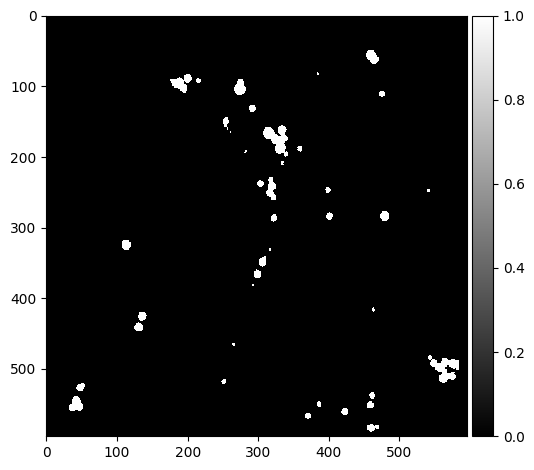

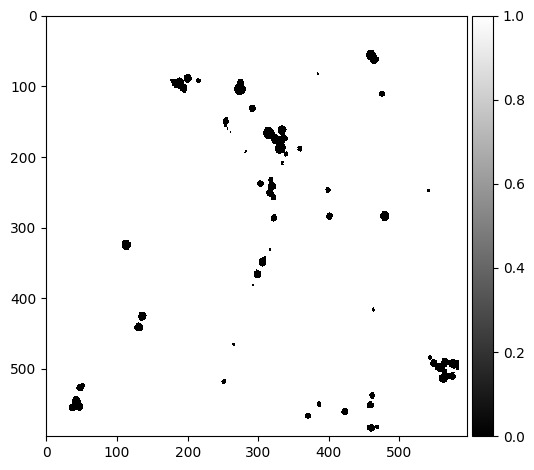

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_02.czi


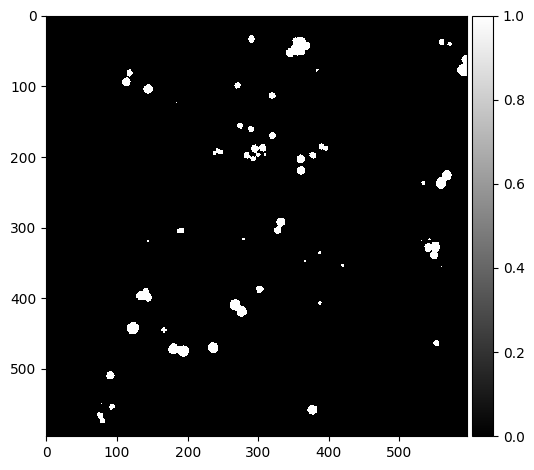

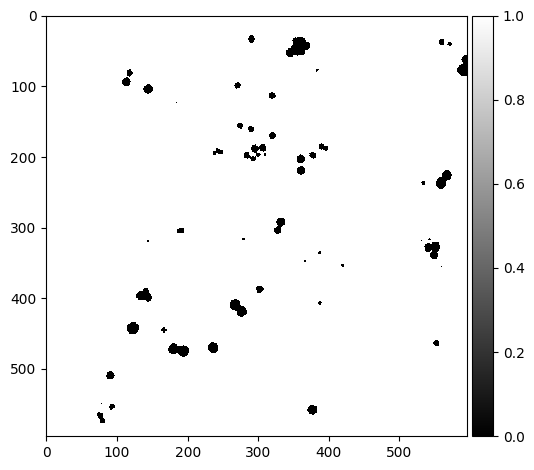

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_03.czi


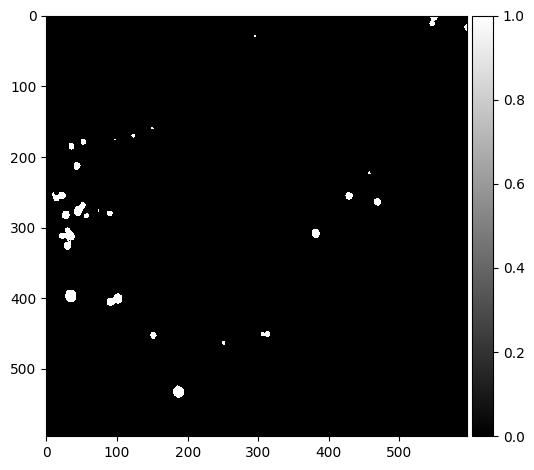

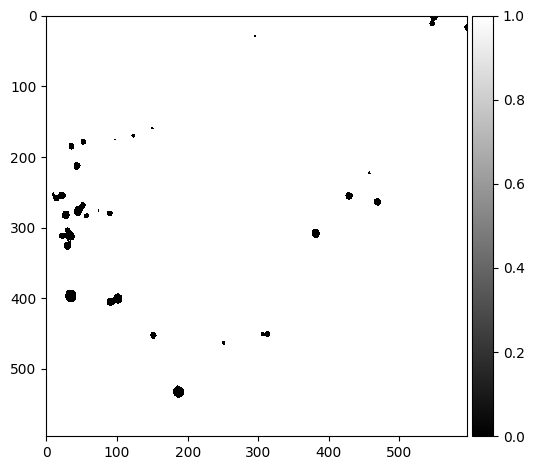

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_04.czi


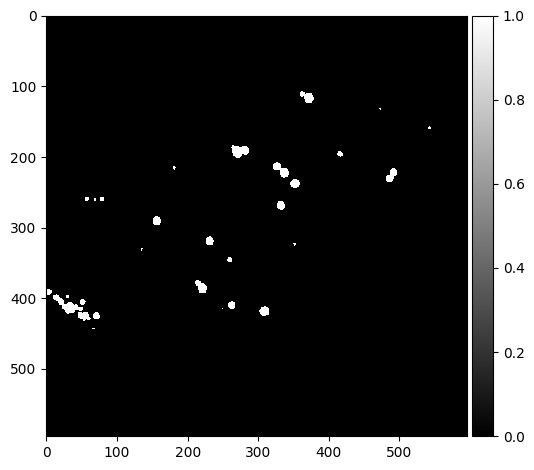

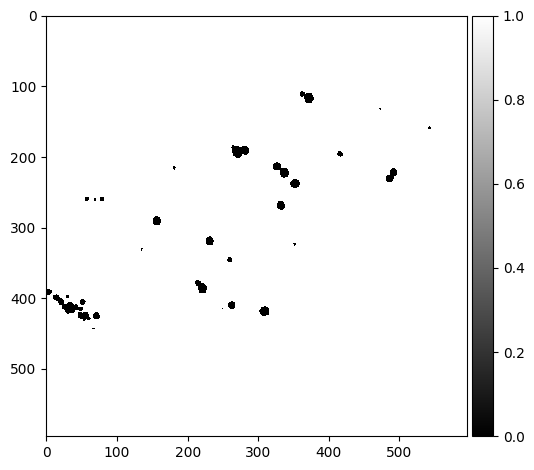

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_05.czi


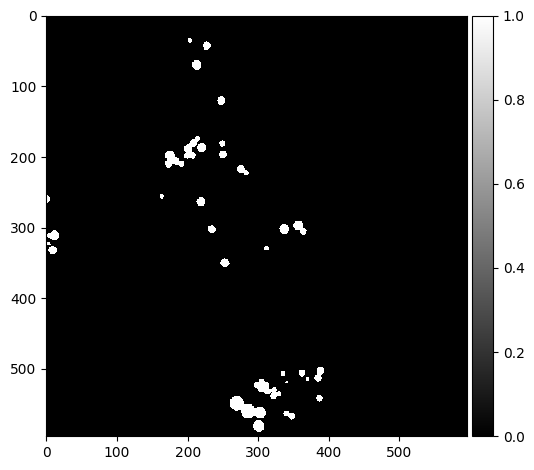

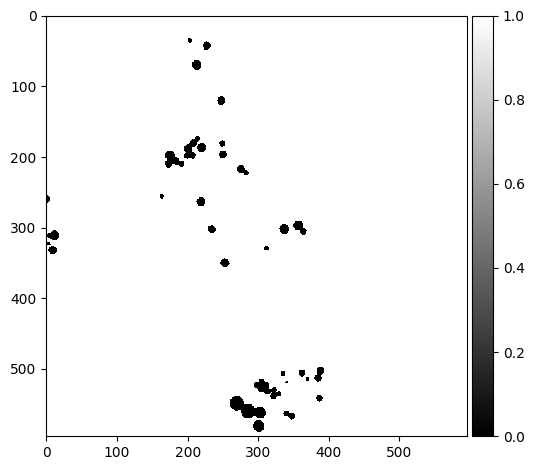

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_06.czi


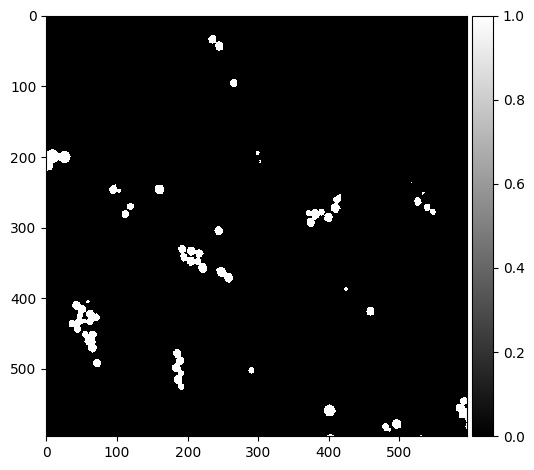

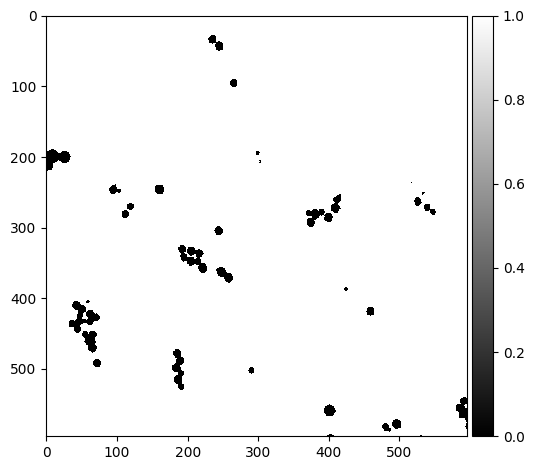

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_07.czi


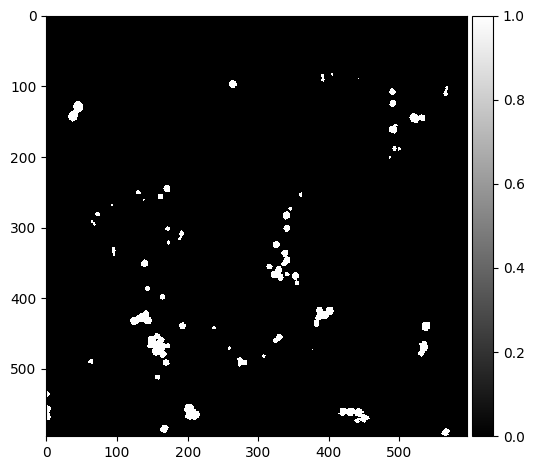

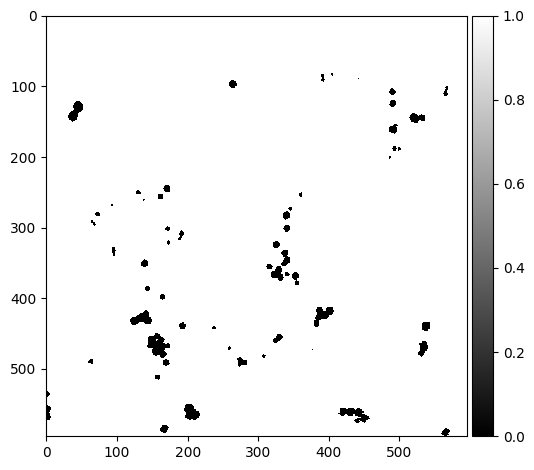

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Bodipy_493-503_conventional_image_08.czi


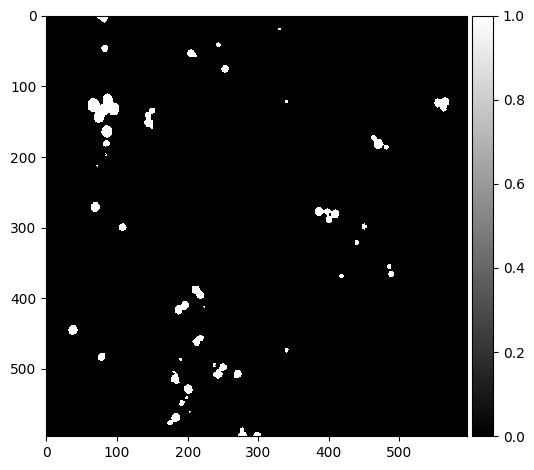

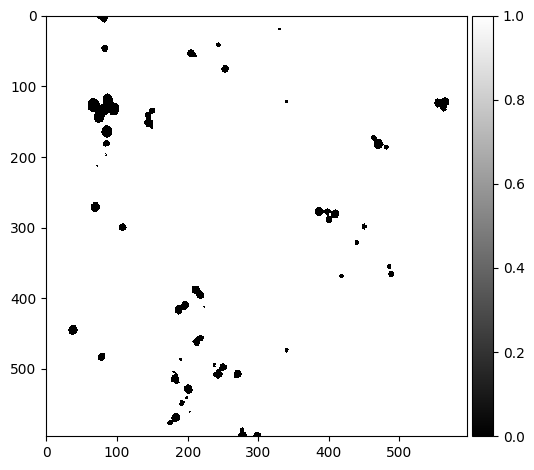

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_01.czi


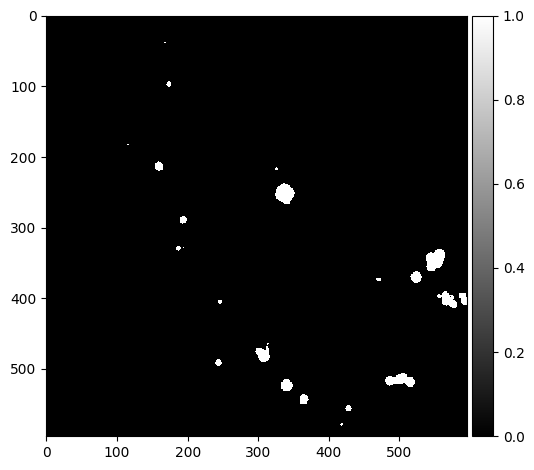

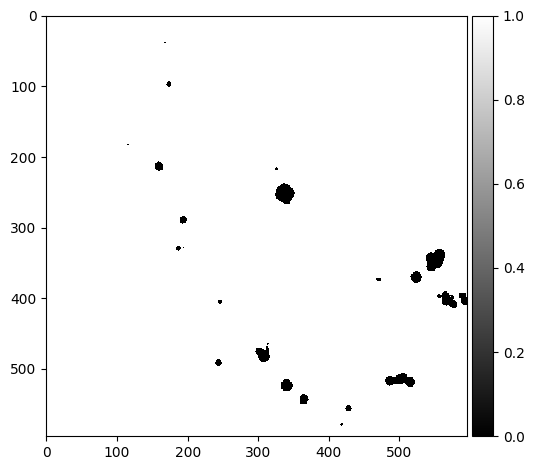

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_02.czi


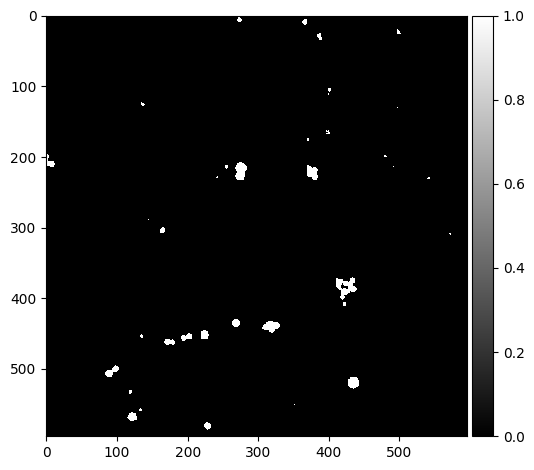

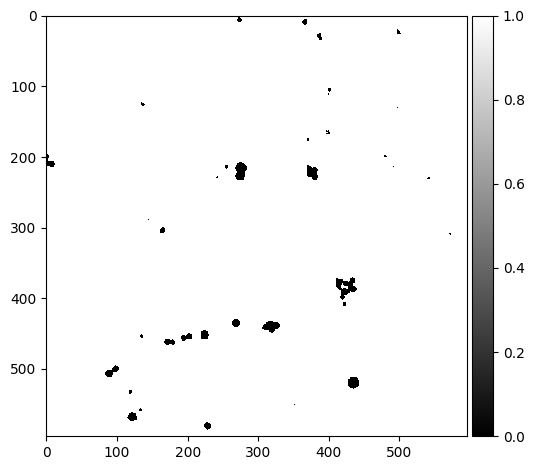

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_03.czi


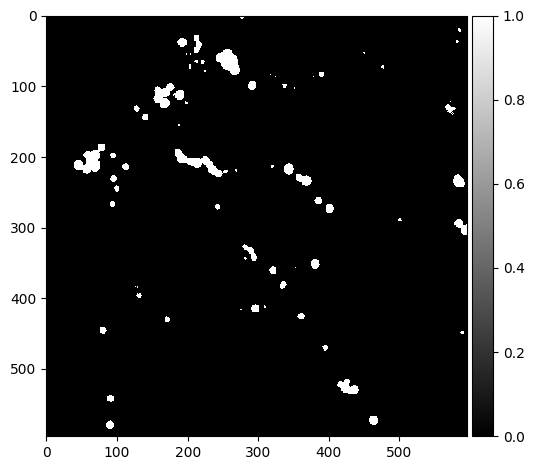

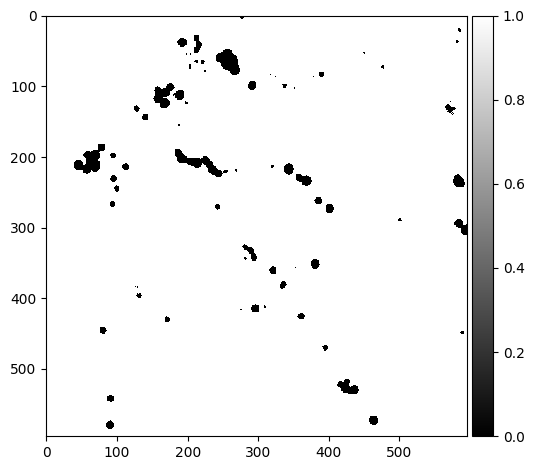

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_04.czi


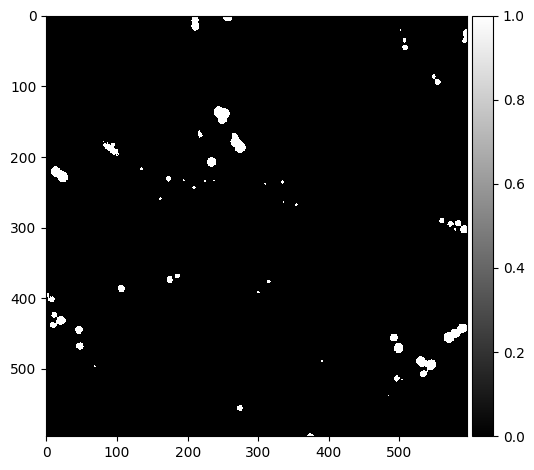

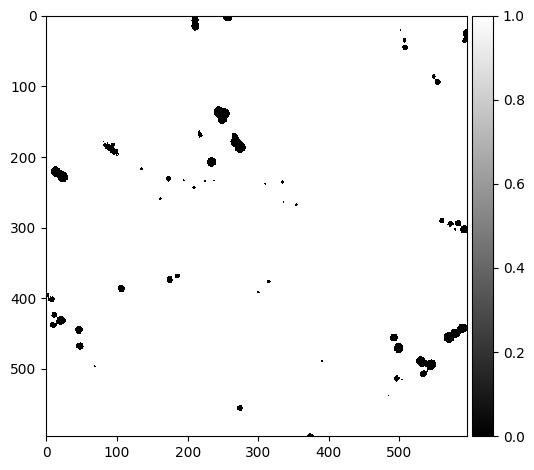

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_05.czi


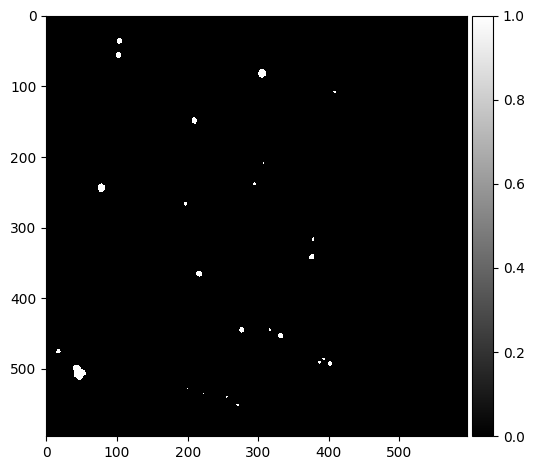

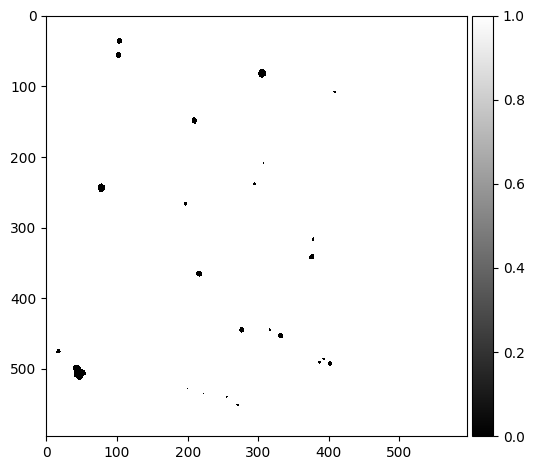

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_06.czi


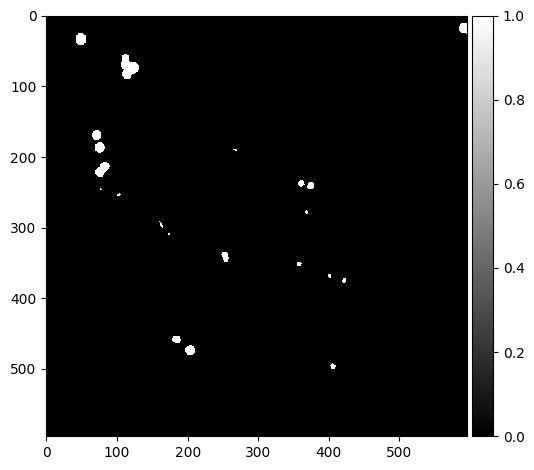

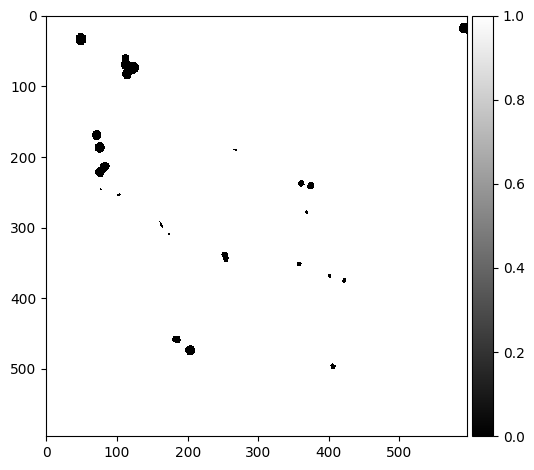

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_07.czi


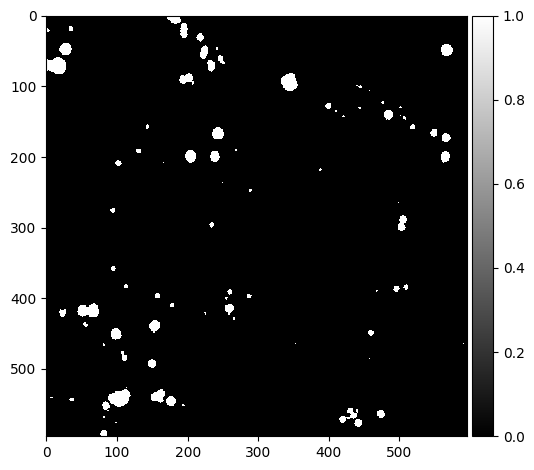

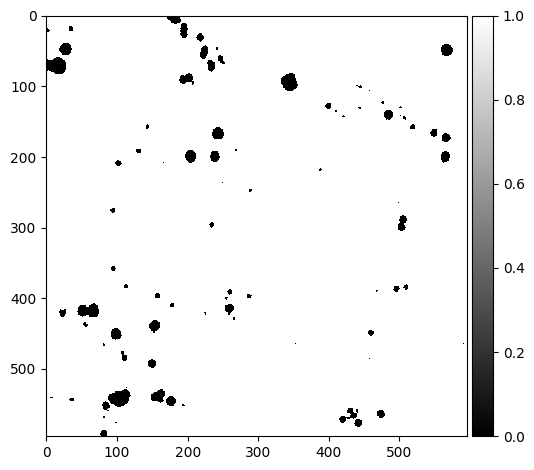

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_Bodipy_493-503_conventional_image_08.czi


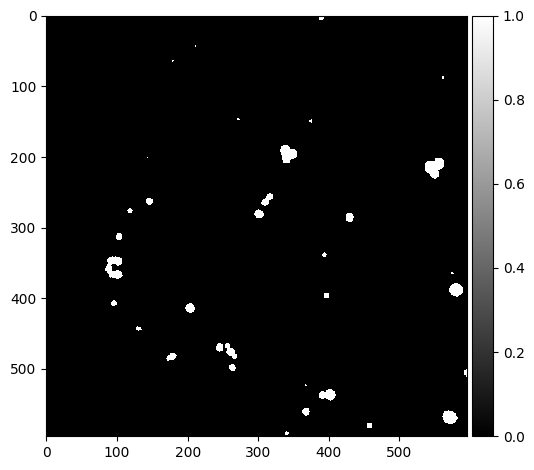

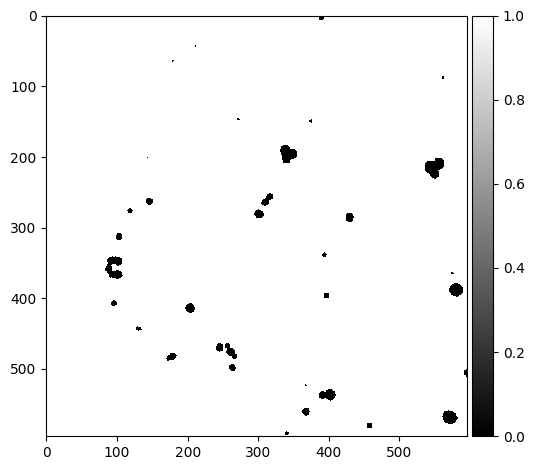

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_01.czi


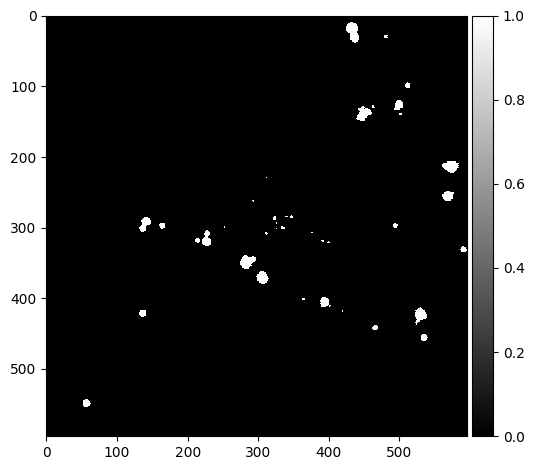

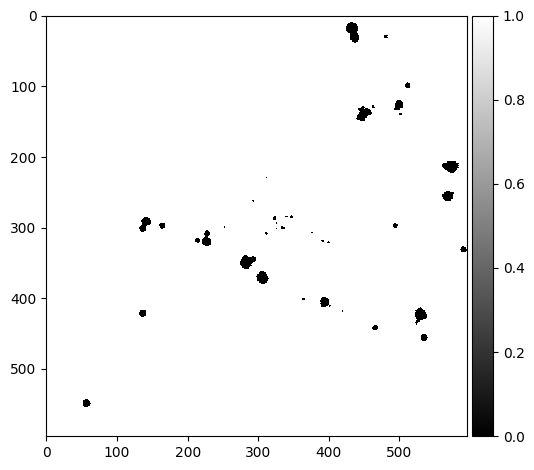

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_02.czi


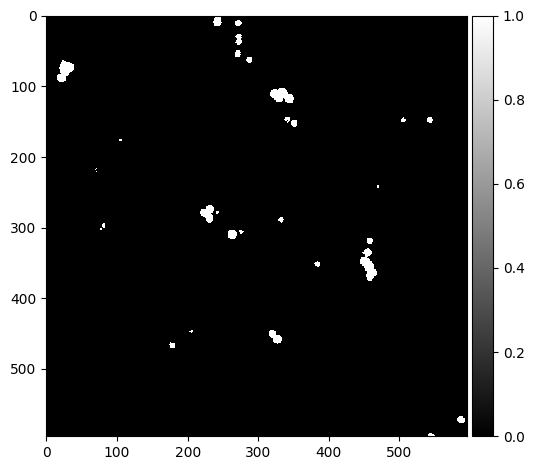

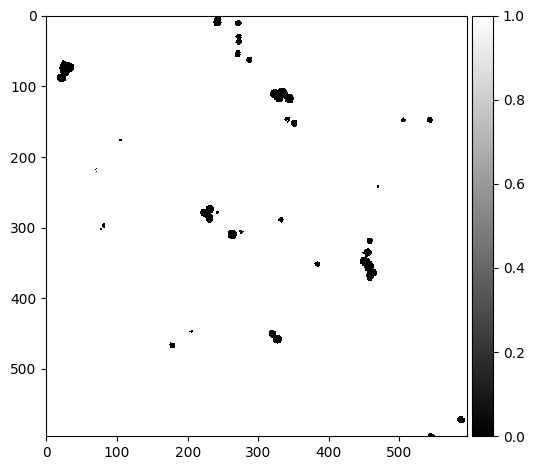

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_03.czi


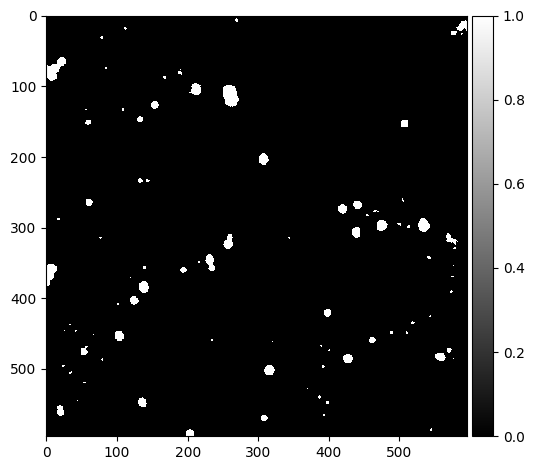

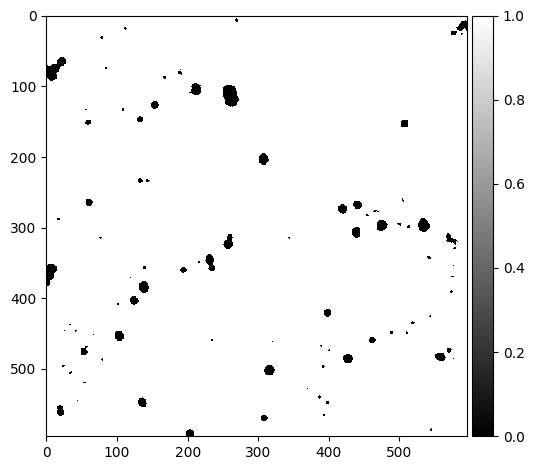

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_04.czi


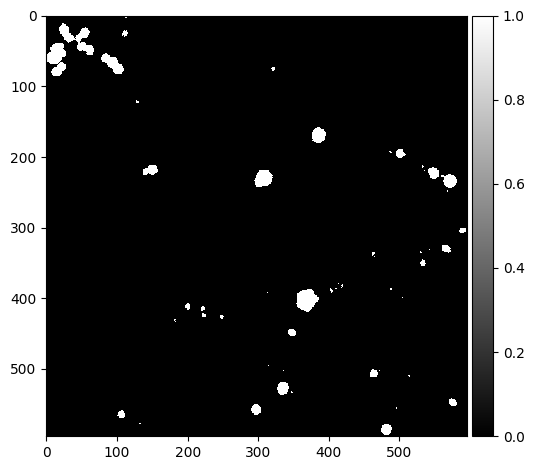

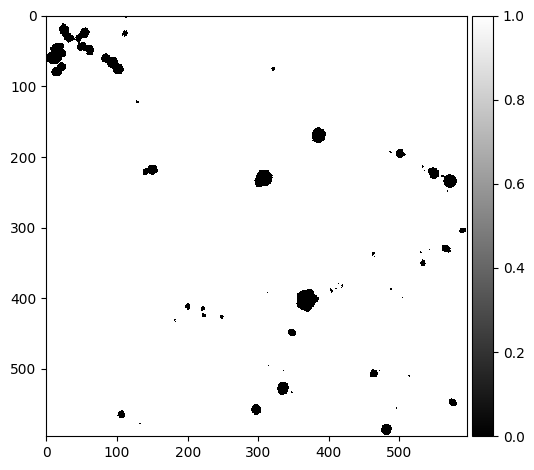

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_05.czi


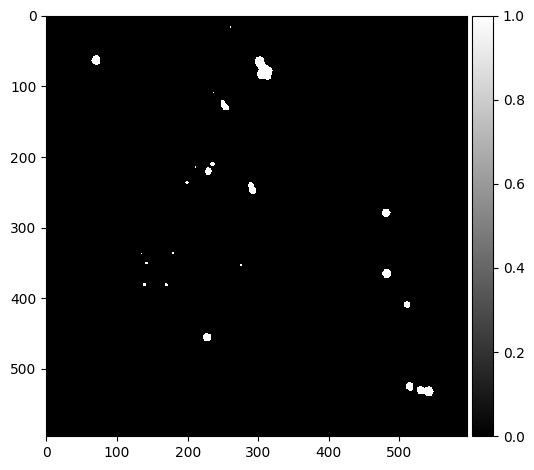

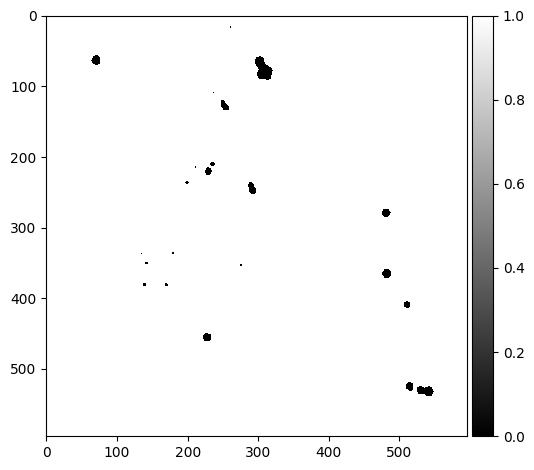

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_06.czi


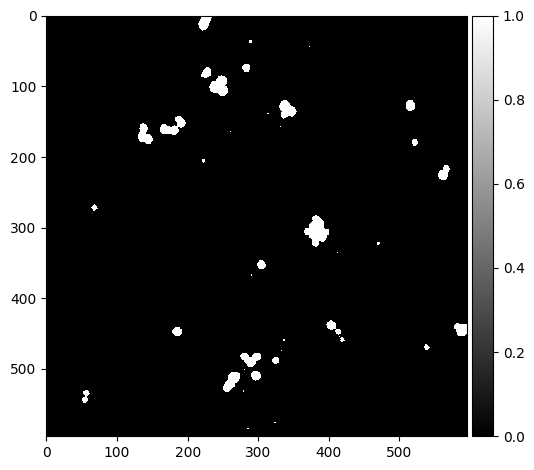

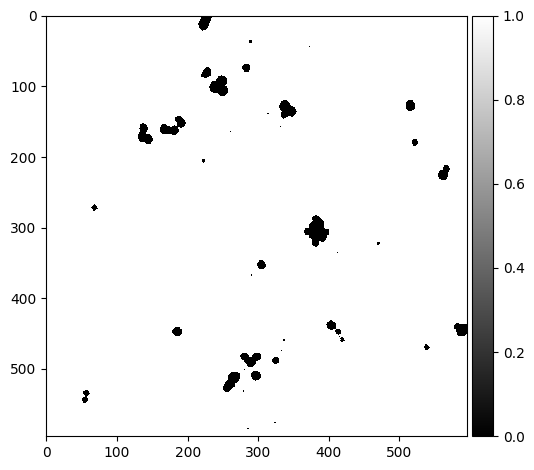

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_07.czi


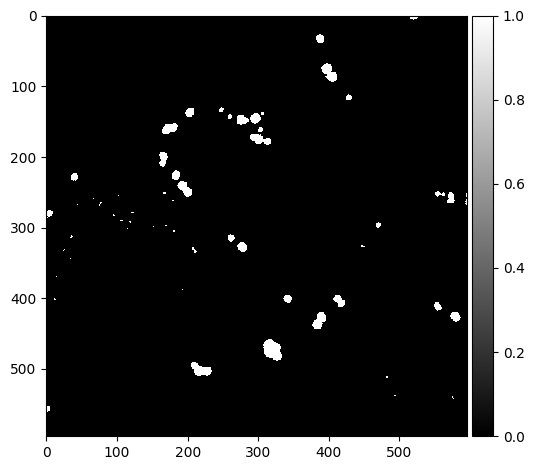

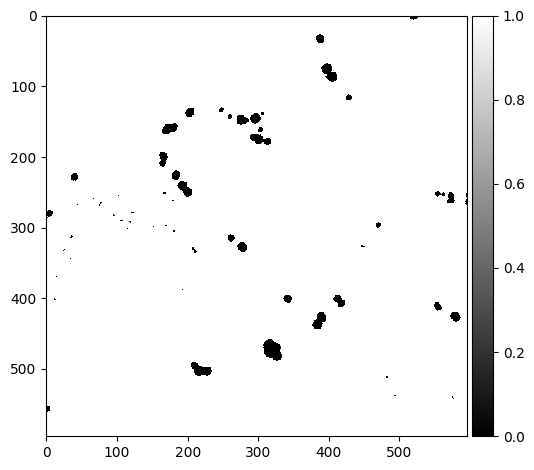

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_conventional_image_08.czi


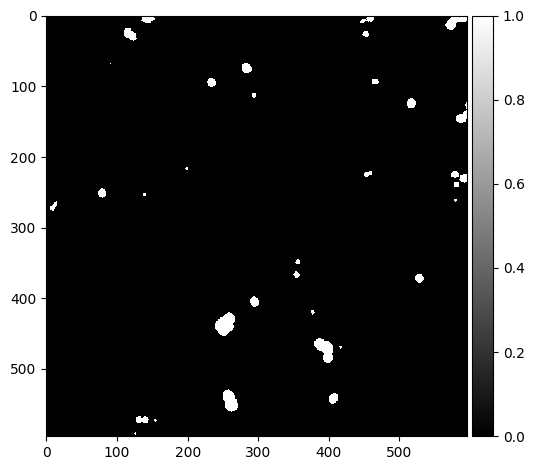

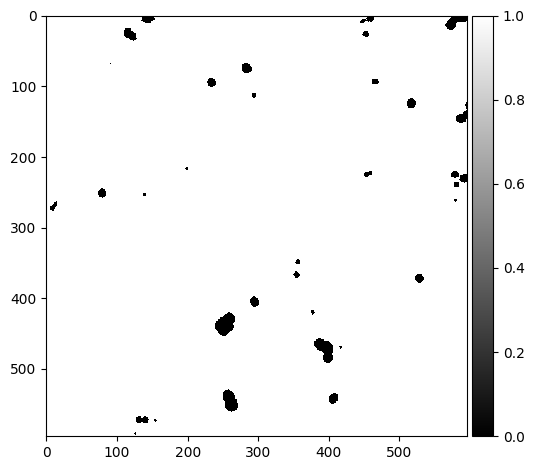

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_01.czi


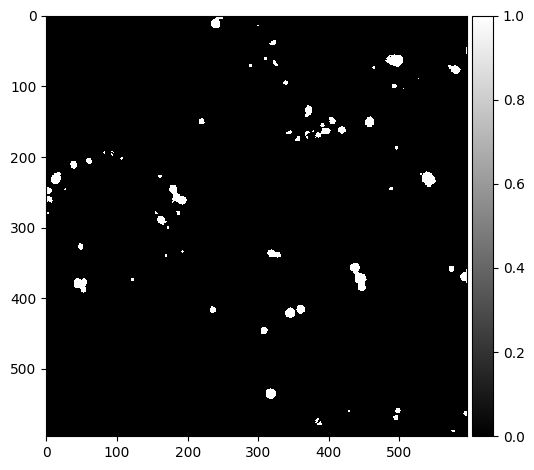

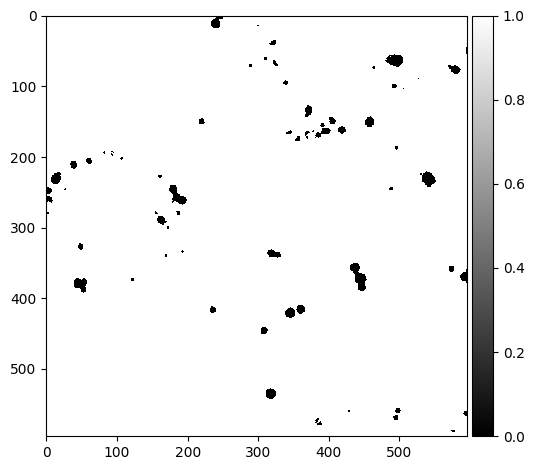

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_02.czi


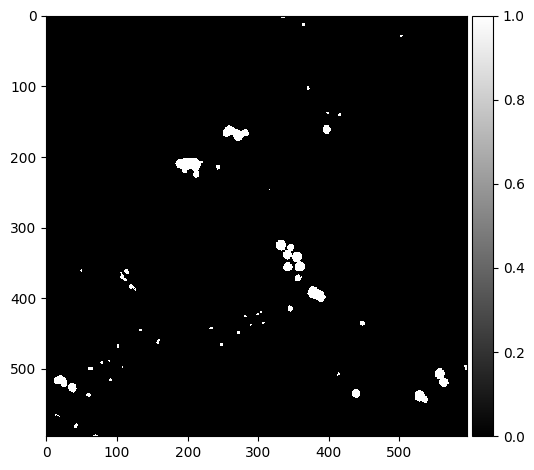

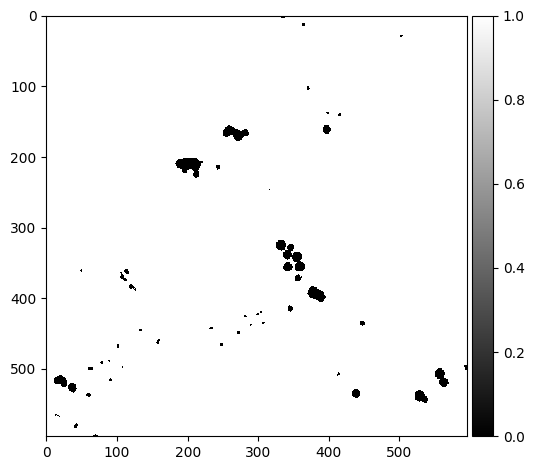

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_03.czi


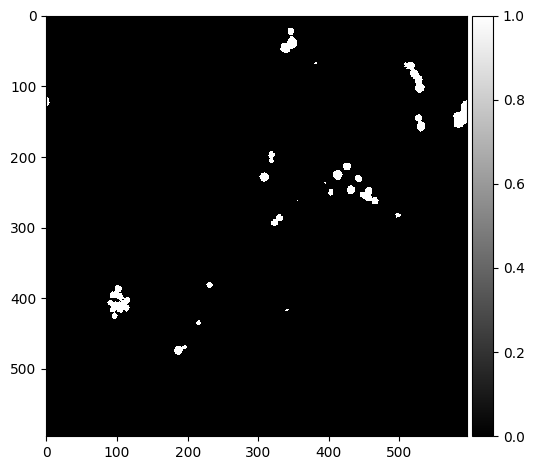

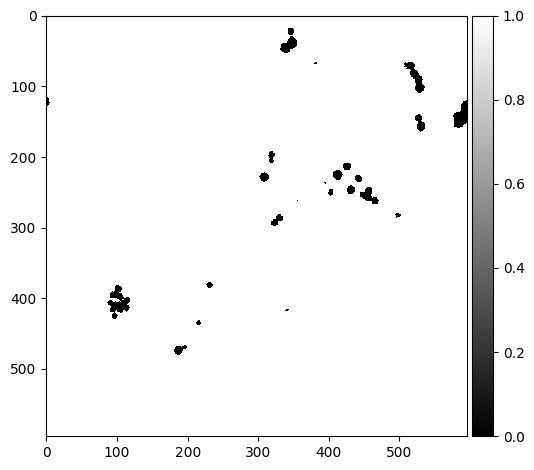

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_04.czi


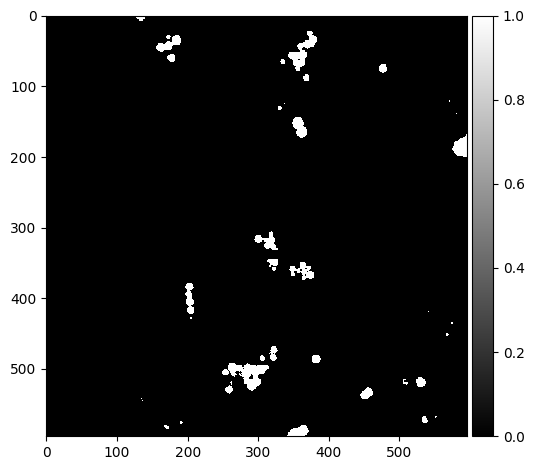

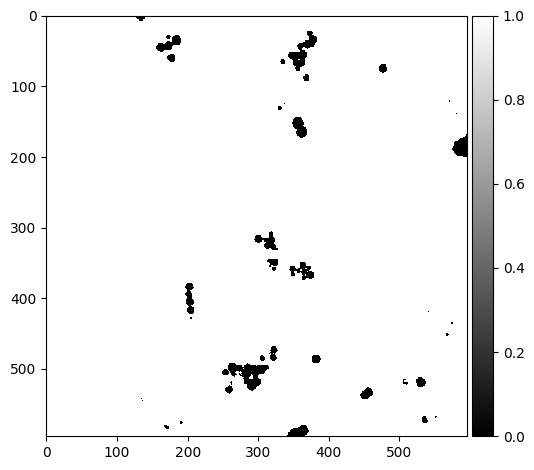

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_05.czi


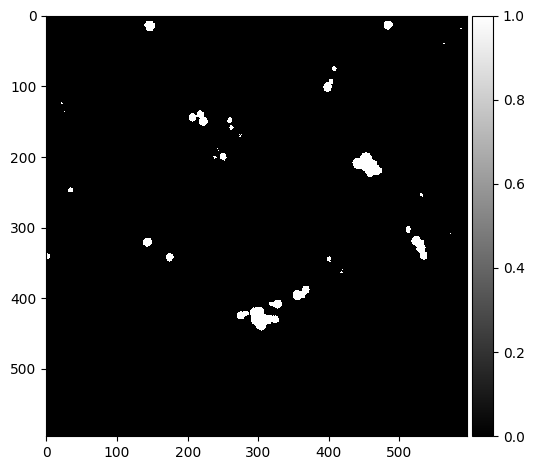

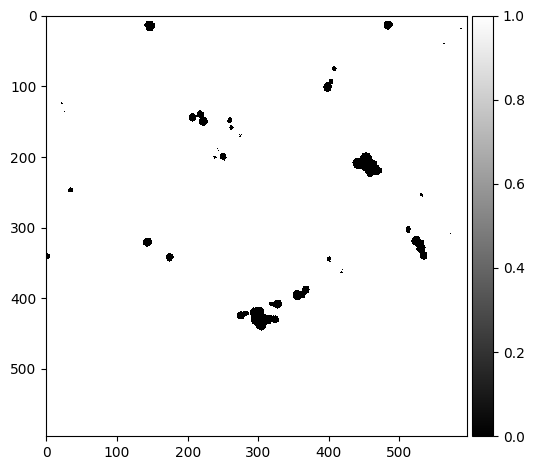

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_06.czi


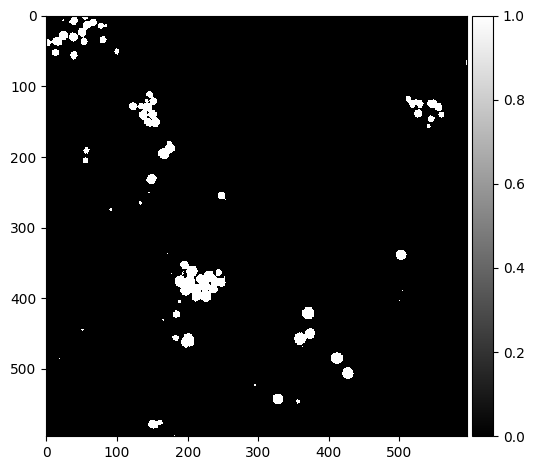

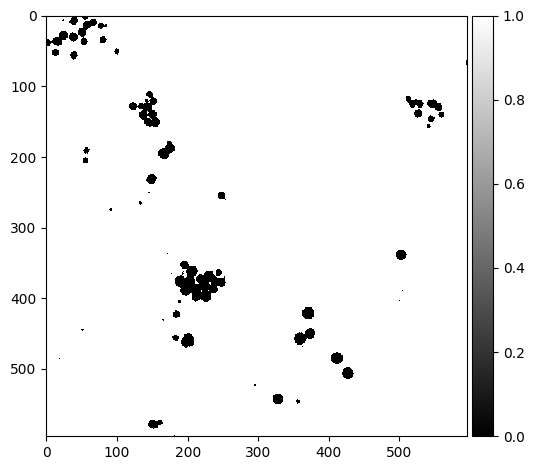

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_07.czi


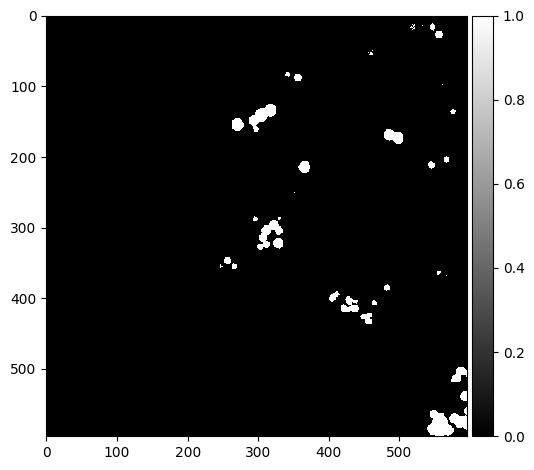

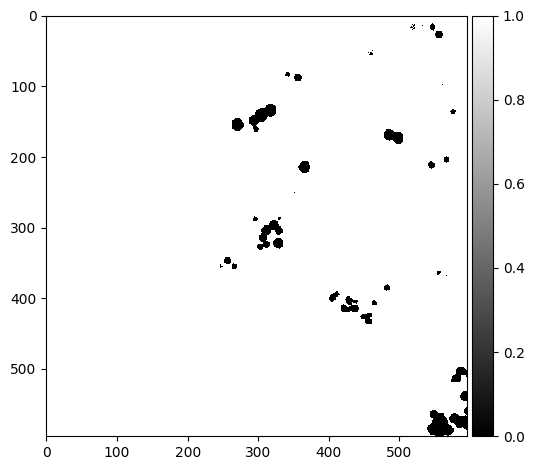

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C12_dox_conventional_image_08.czi


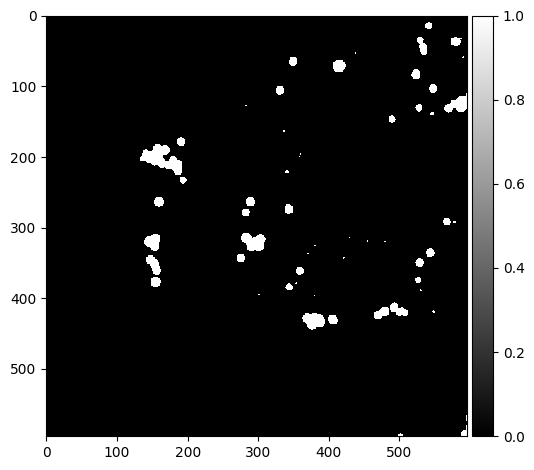

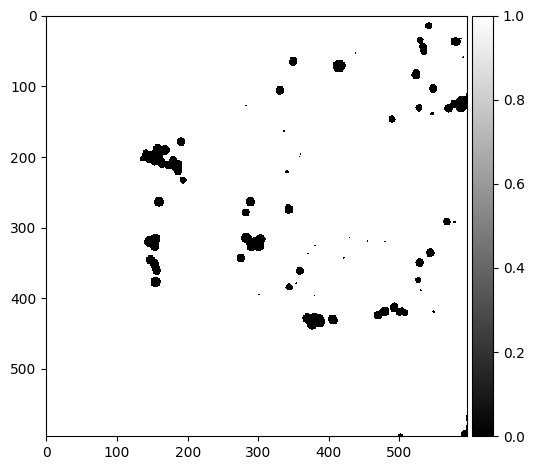

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_01.czi


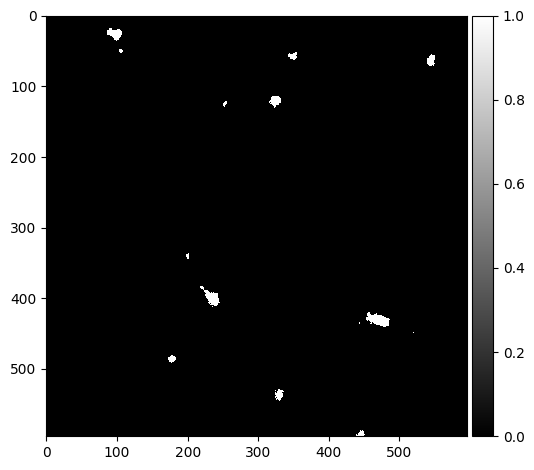

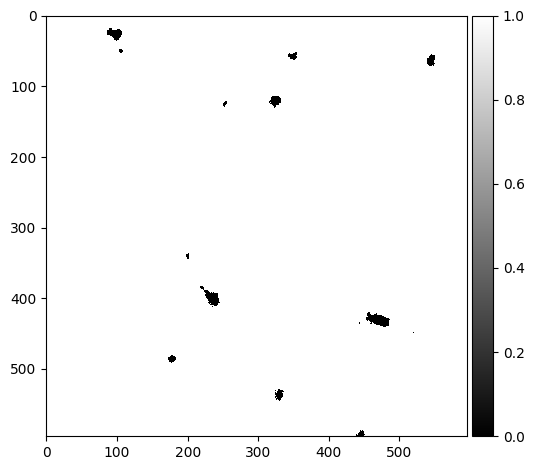

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_02.czi


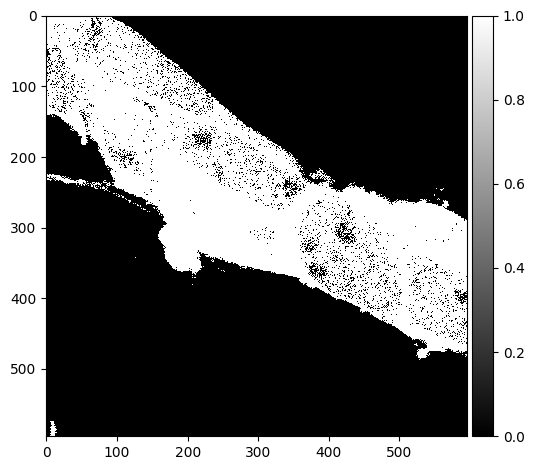

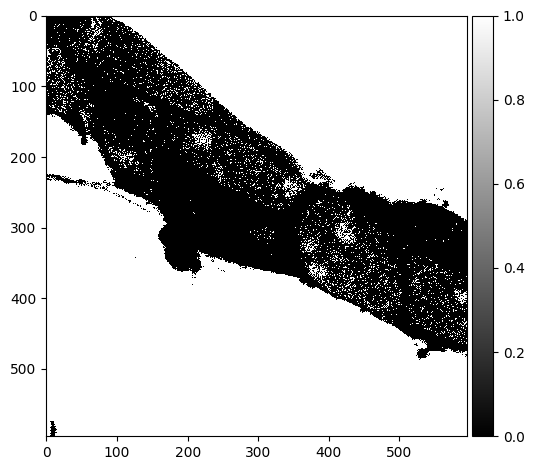

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_03.czi


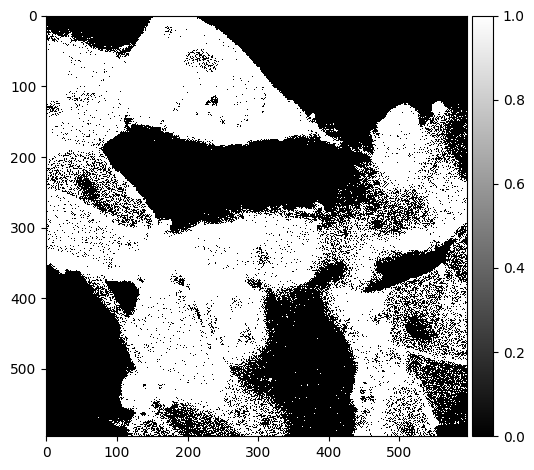

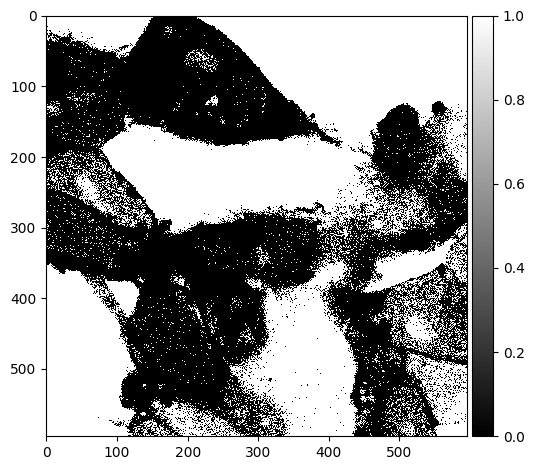

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_04.czi


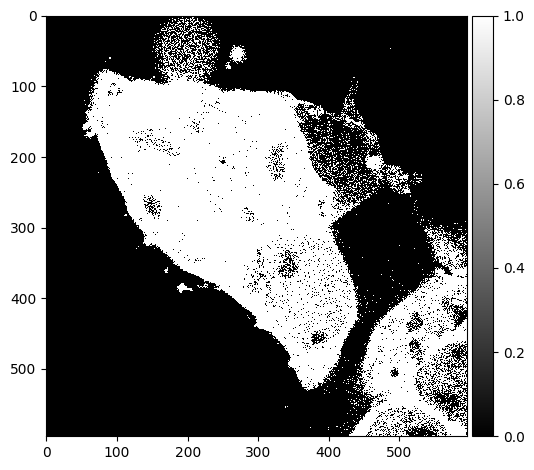

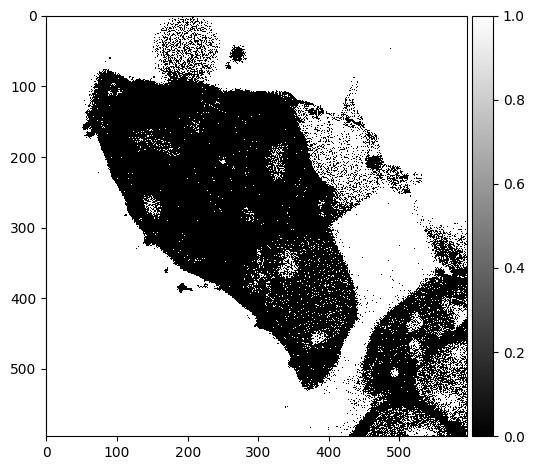

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_05.czi


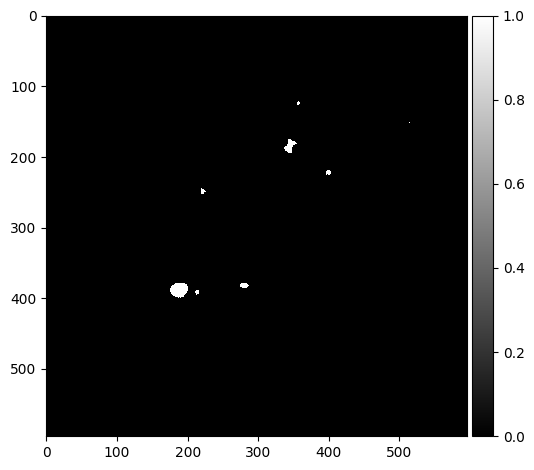

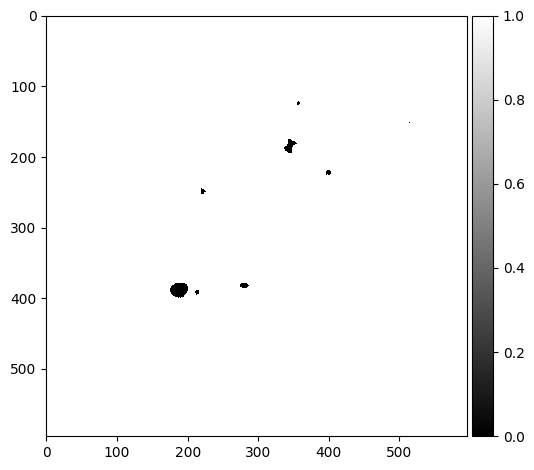

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_06.czi


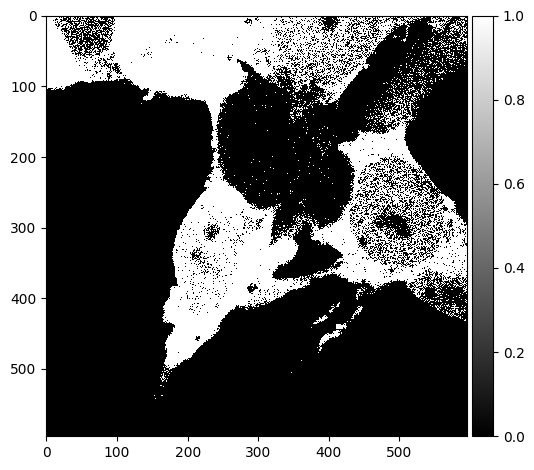

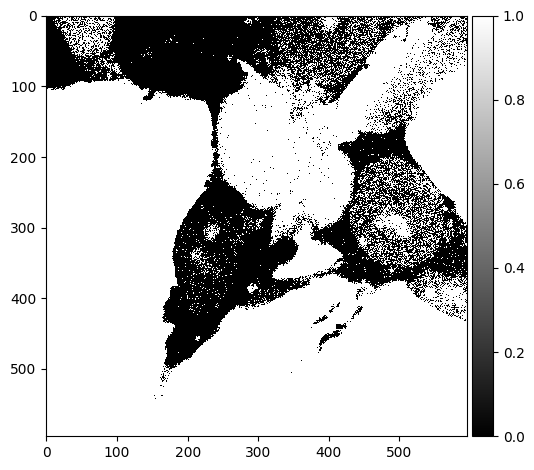

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_07.czi


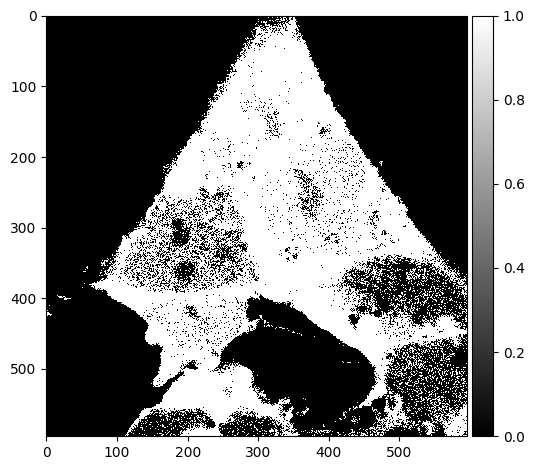

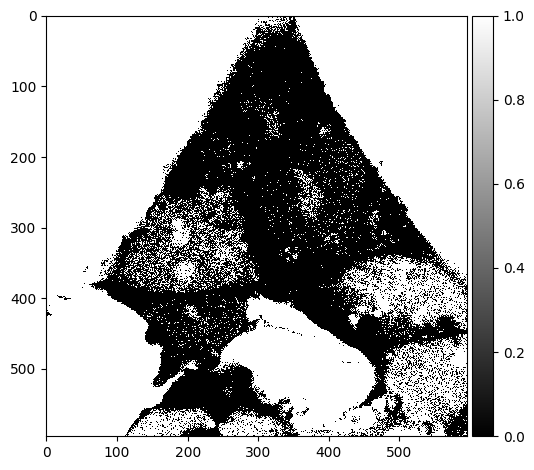

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dox_conventional_image_08.czi


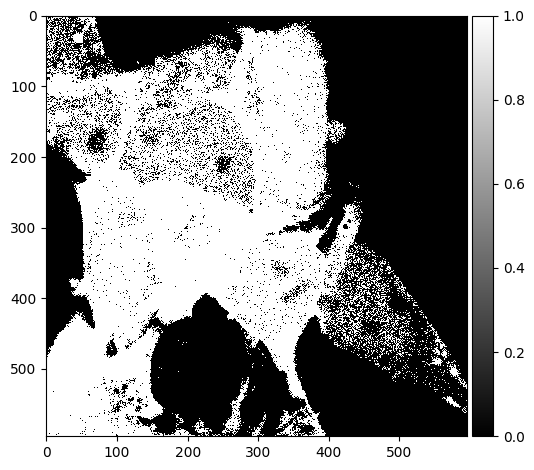

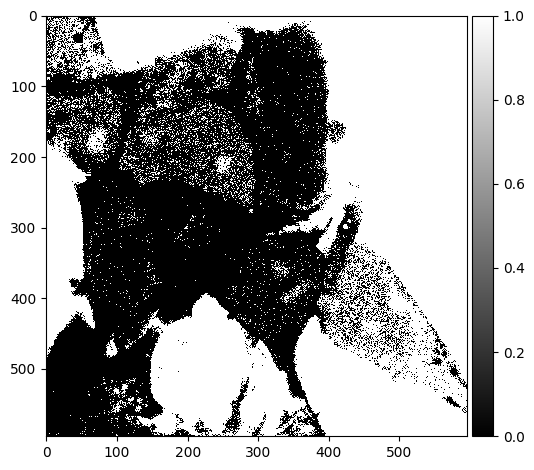

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [6]:
analyze_all_subfolders(folder)
